In [1]:
import pandas as pd
import numpy as np
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.metrics import get_time_dependent_gt

joinit_info = pd.read_csv('data/joinit_info_HR.csv')
joinit_info

,case_id,risk,survival,event,risk_group,survival_type,cohort
0,1,3.955,106.4,0,High Risk,OS,Training
1,10,1.023,22.3,1,High Risk,OS,Training
2,1000,4.000,8.4,0,Low Risk,OS,Training
3,1002,4.000,45.3,0,Low Risk,OS,Training
4,1005,4.000,45.7,0,High Risk,OS,Training
...,...,...,...,...,...,...,...
1417,58,2.905,8.0,0,Low Risk,PFS,External C
1418,60,2.148,14.5,0,High Risk,PFS,External C
1419,61,2.842,18.0,0,Low Risk,PFS,External C
1420,62,2.838,12.1,0,Low Risk,PFS,External C


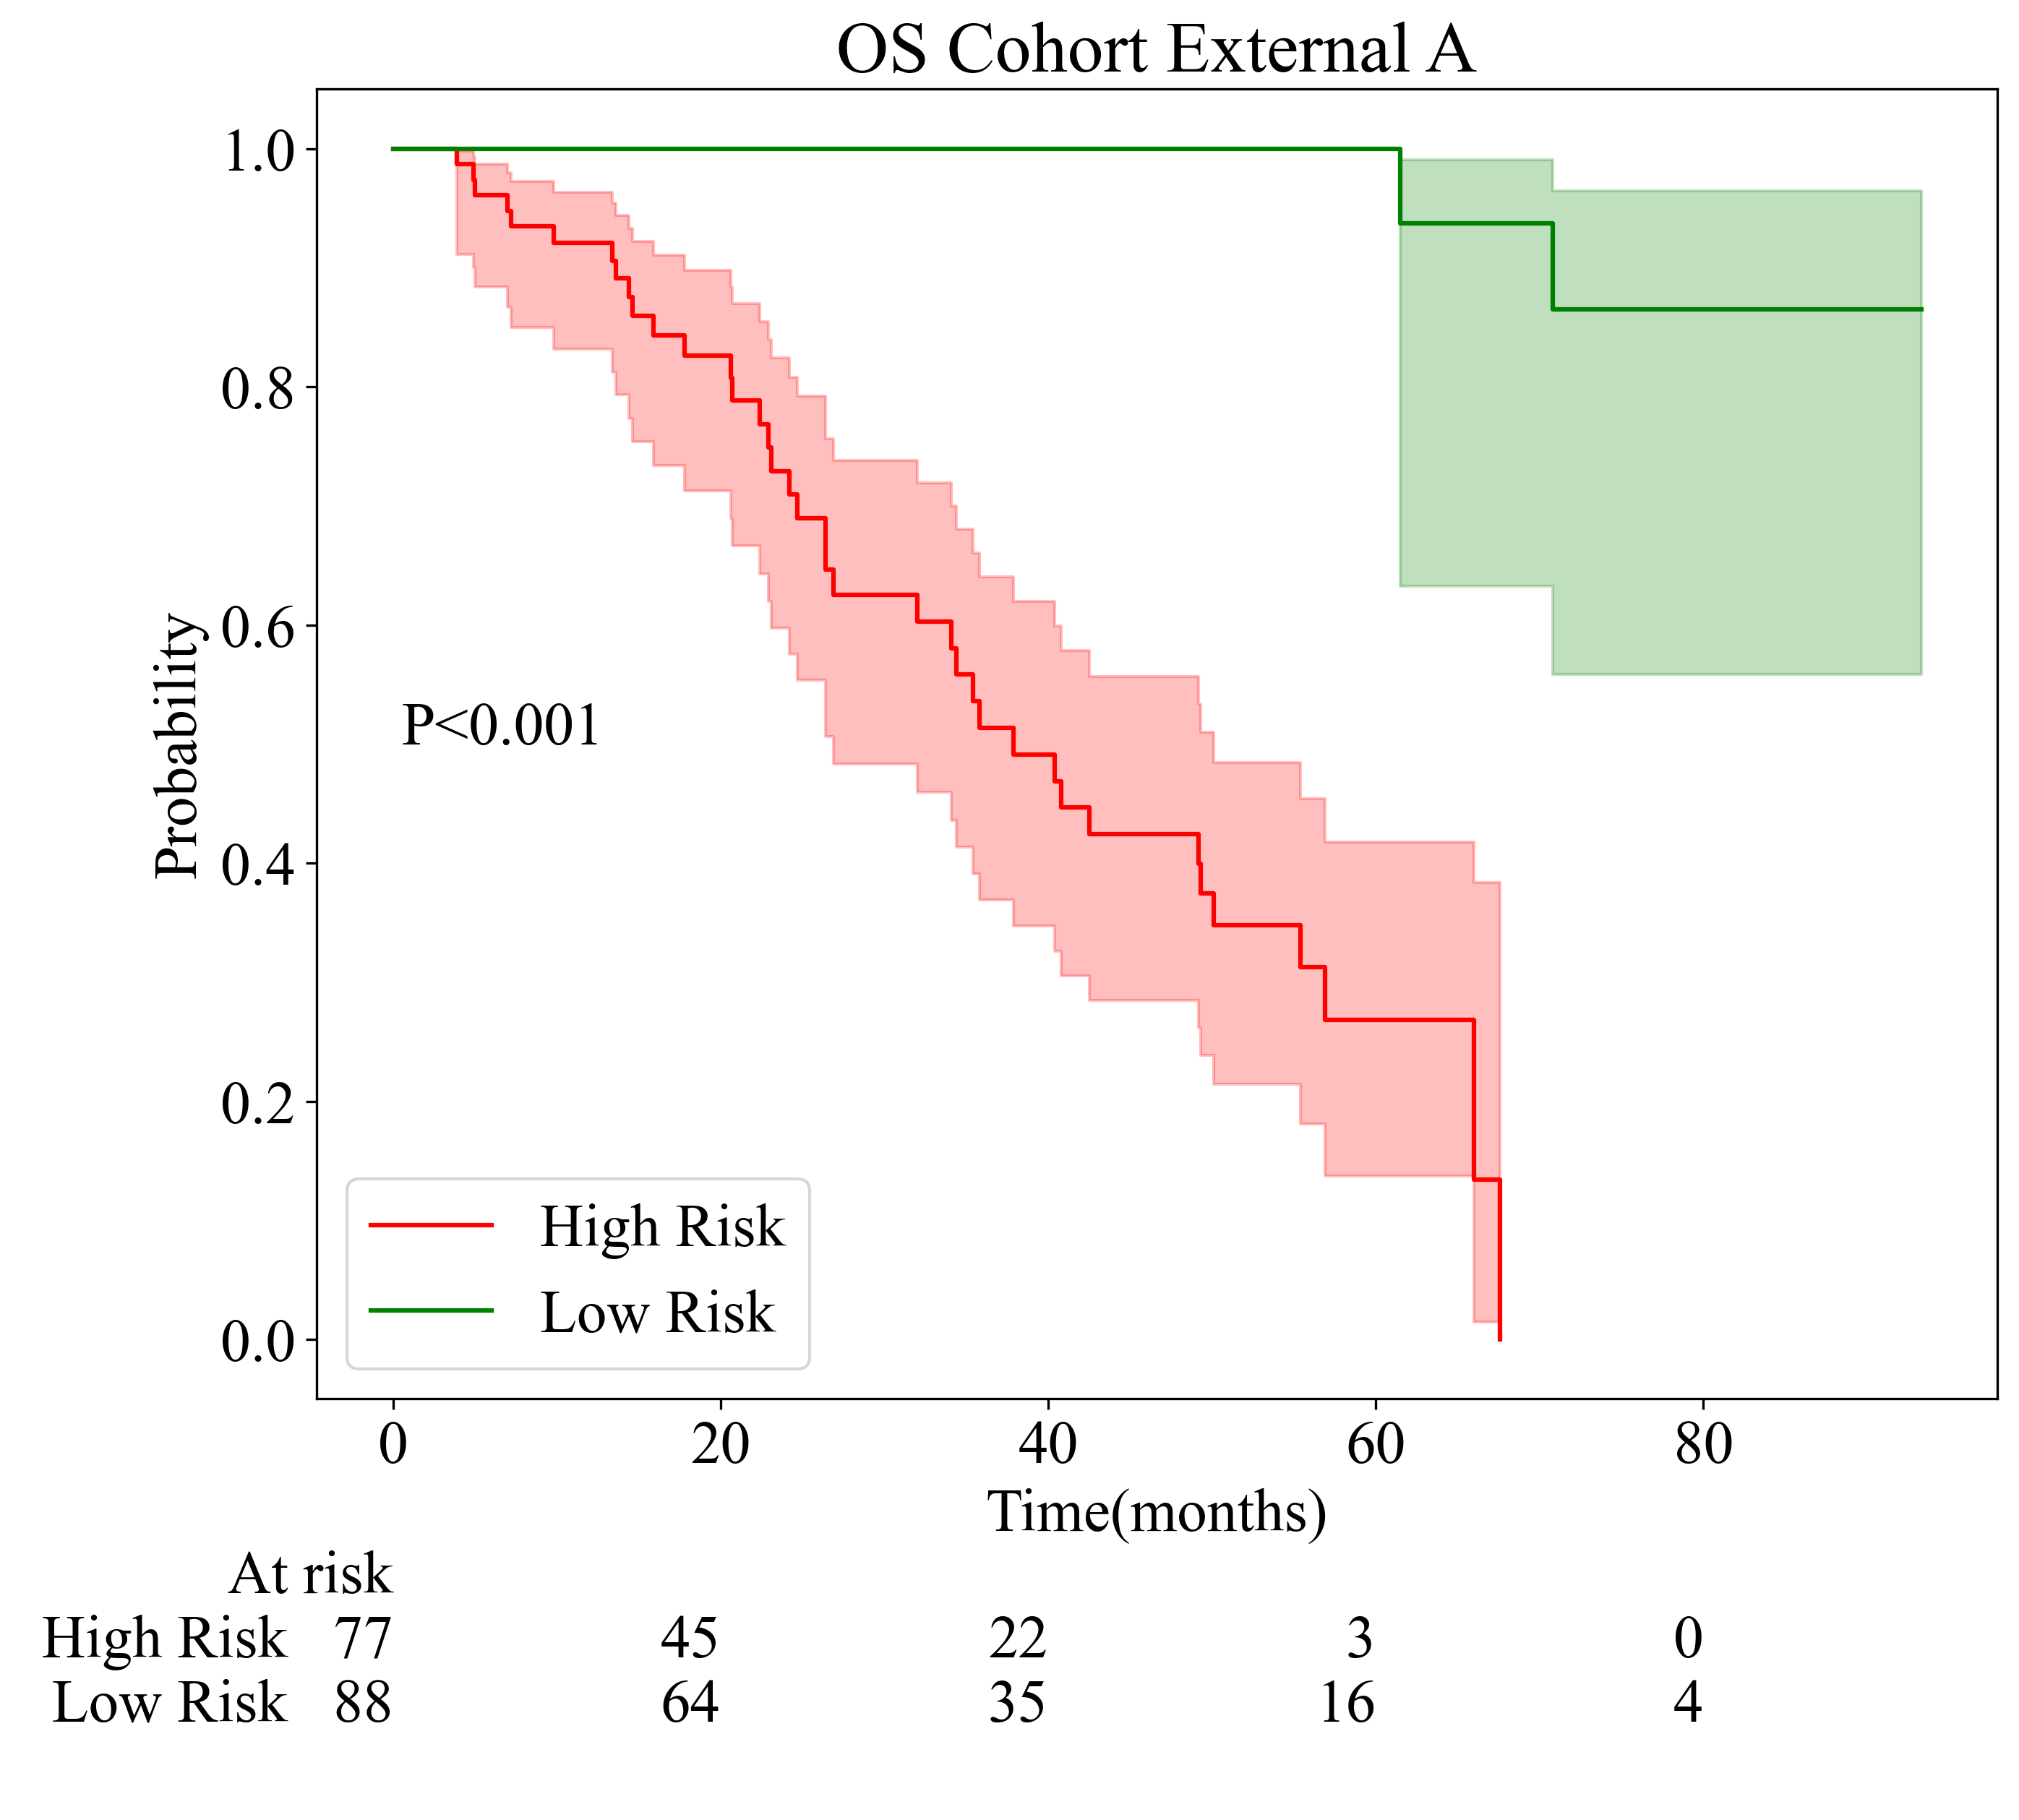

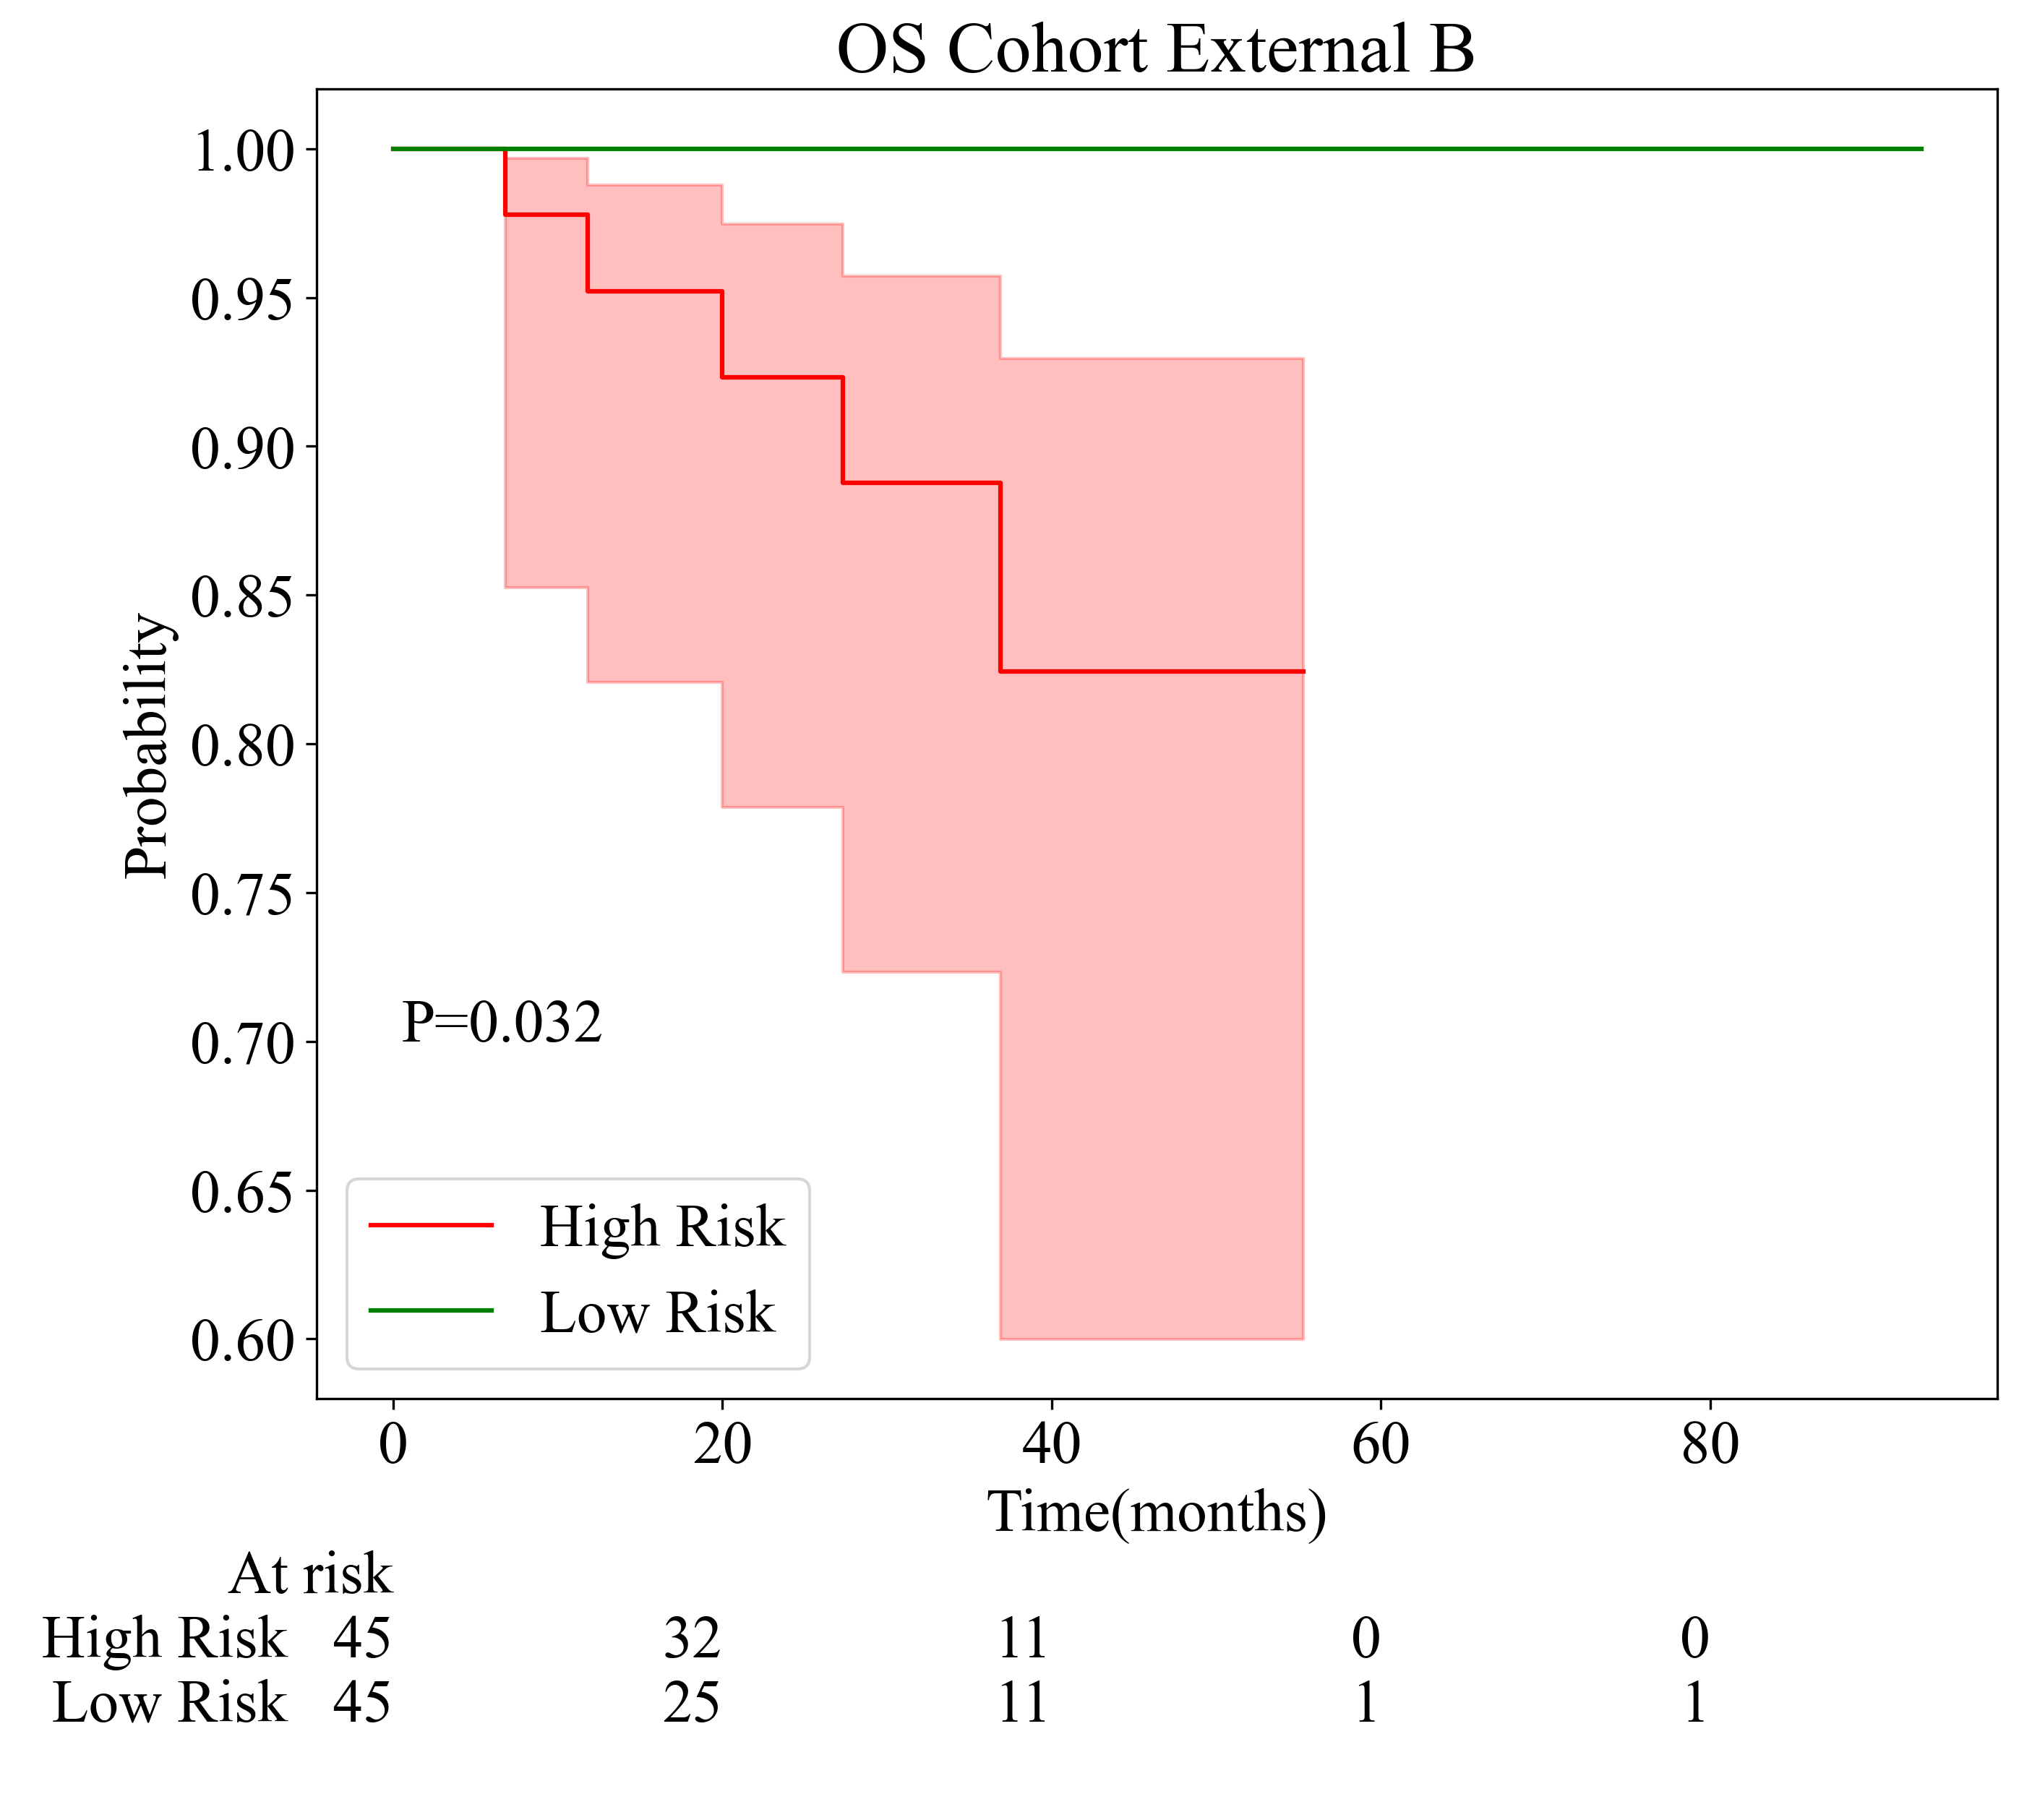

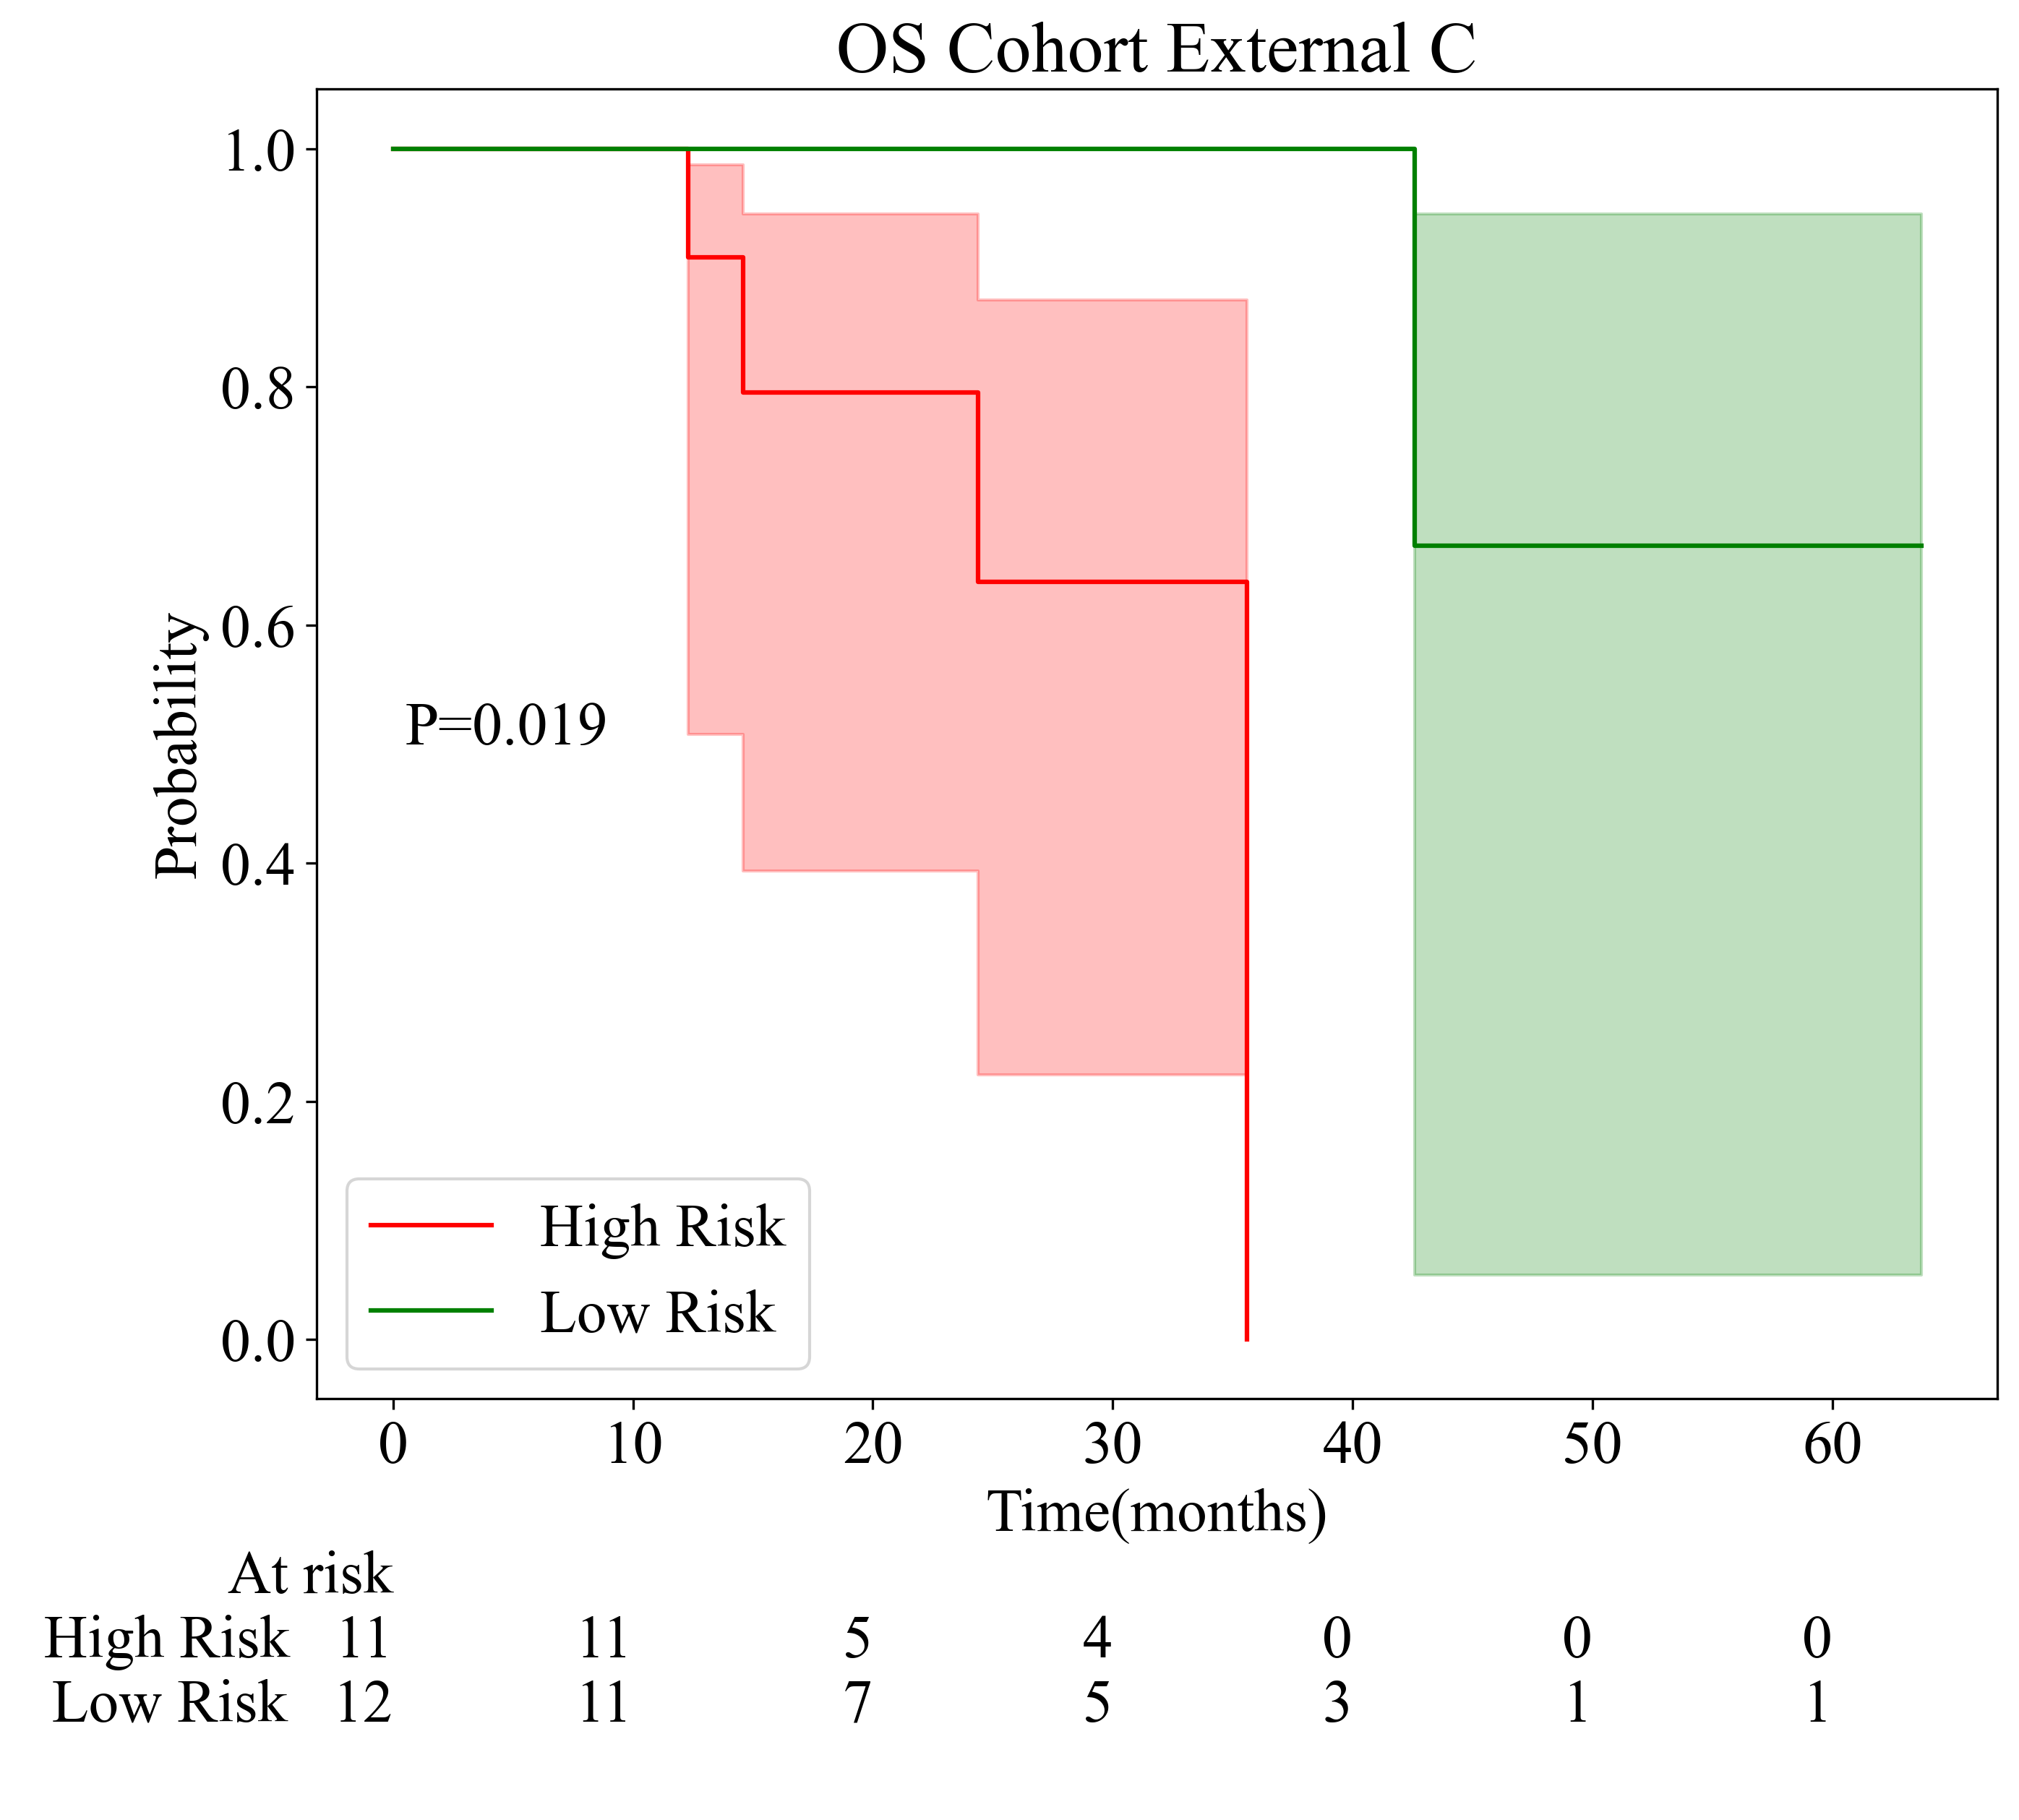

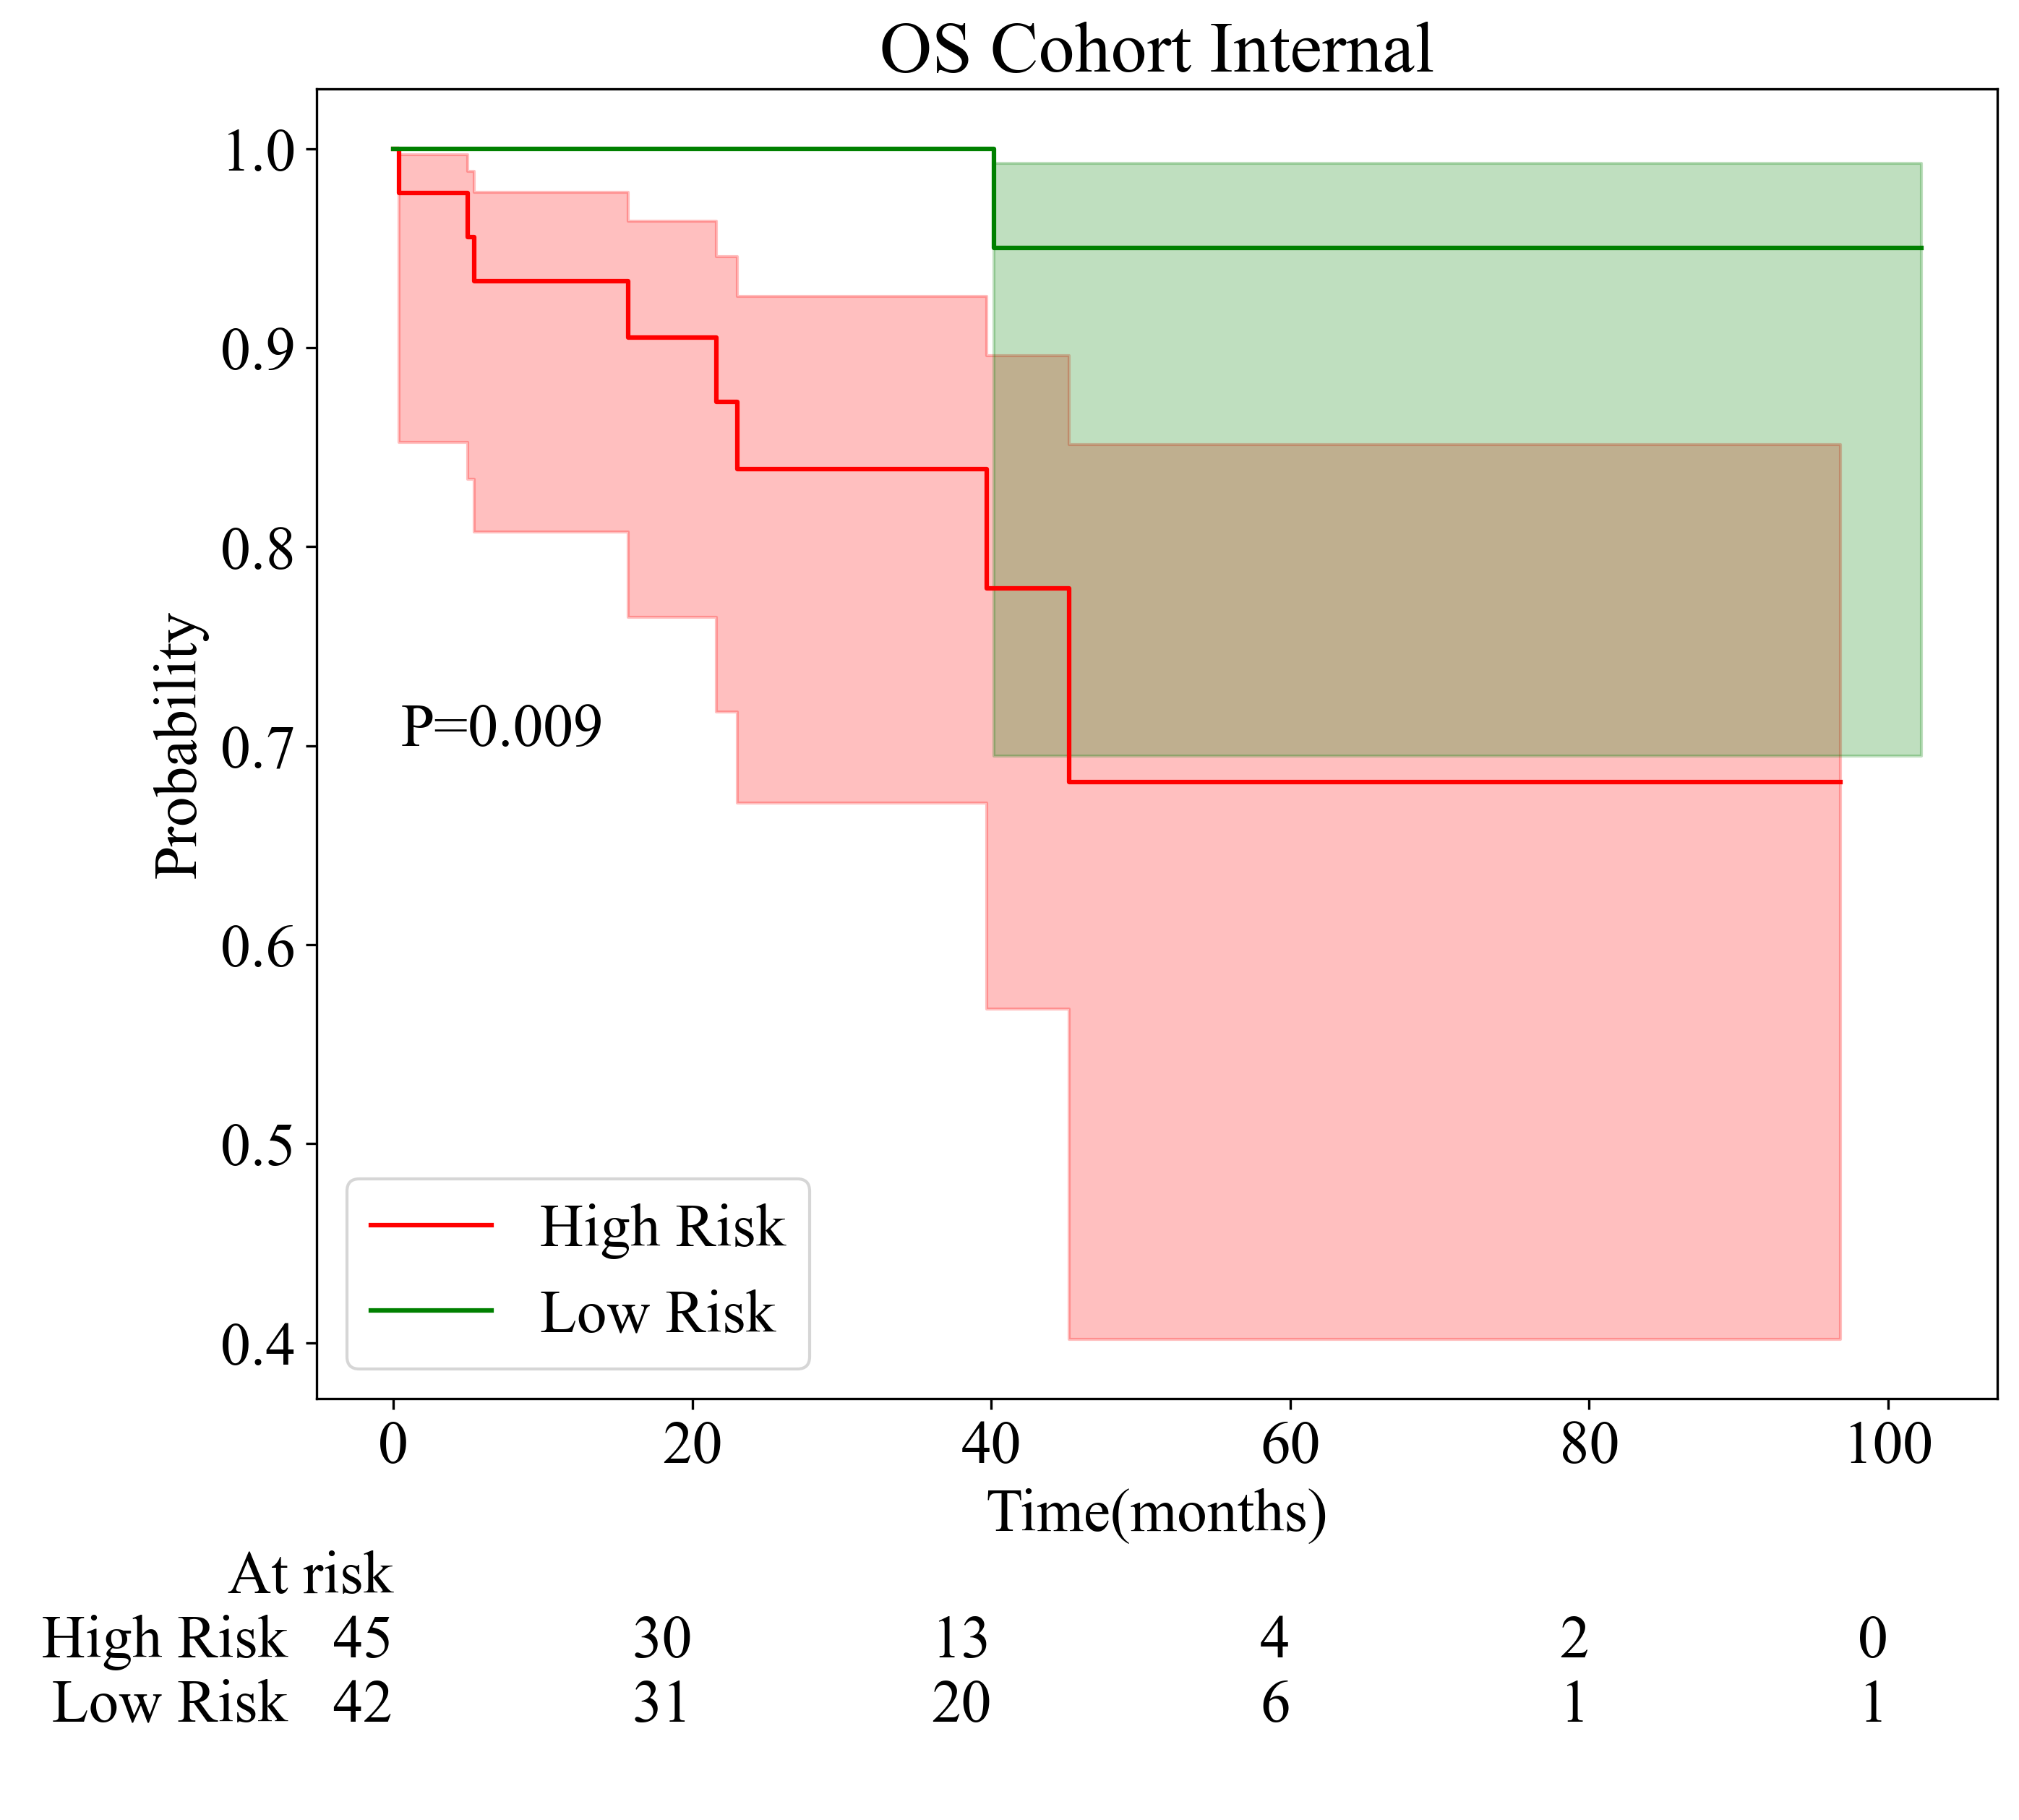

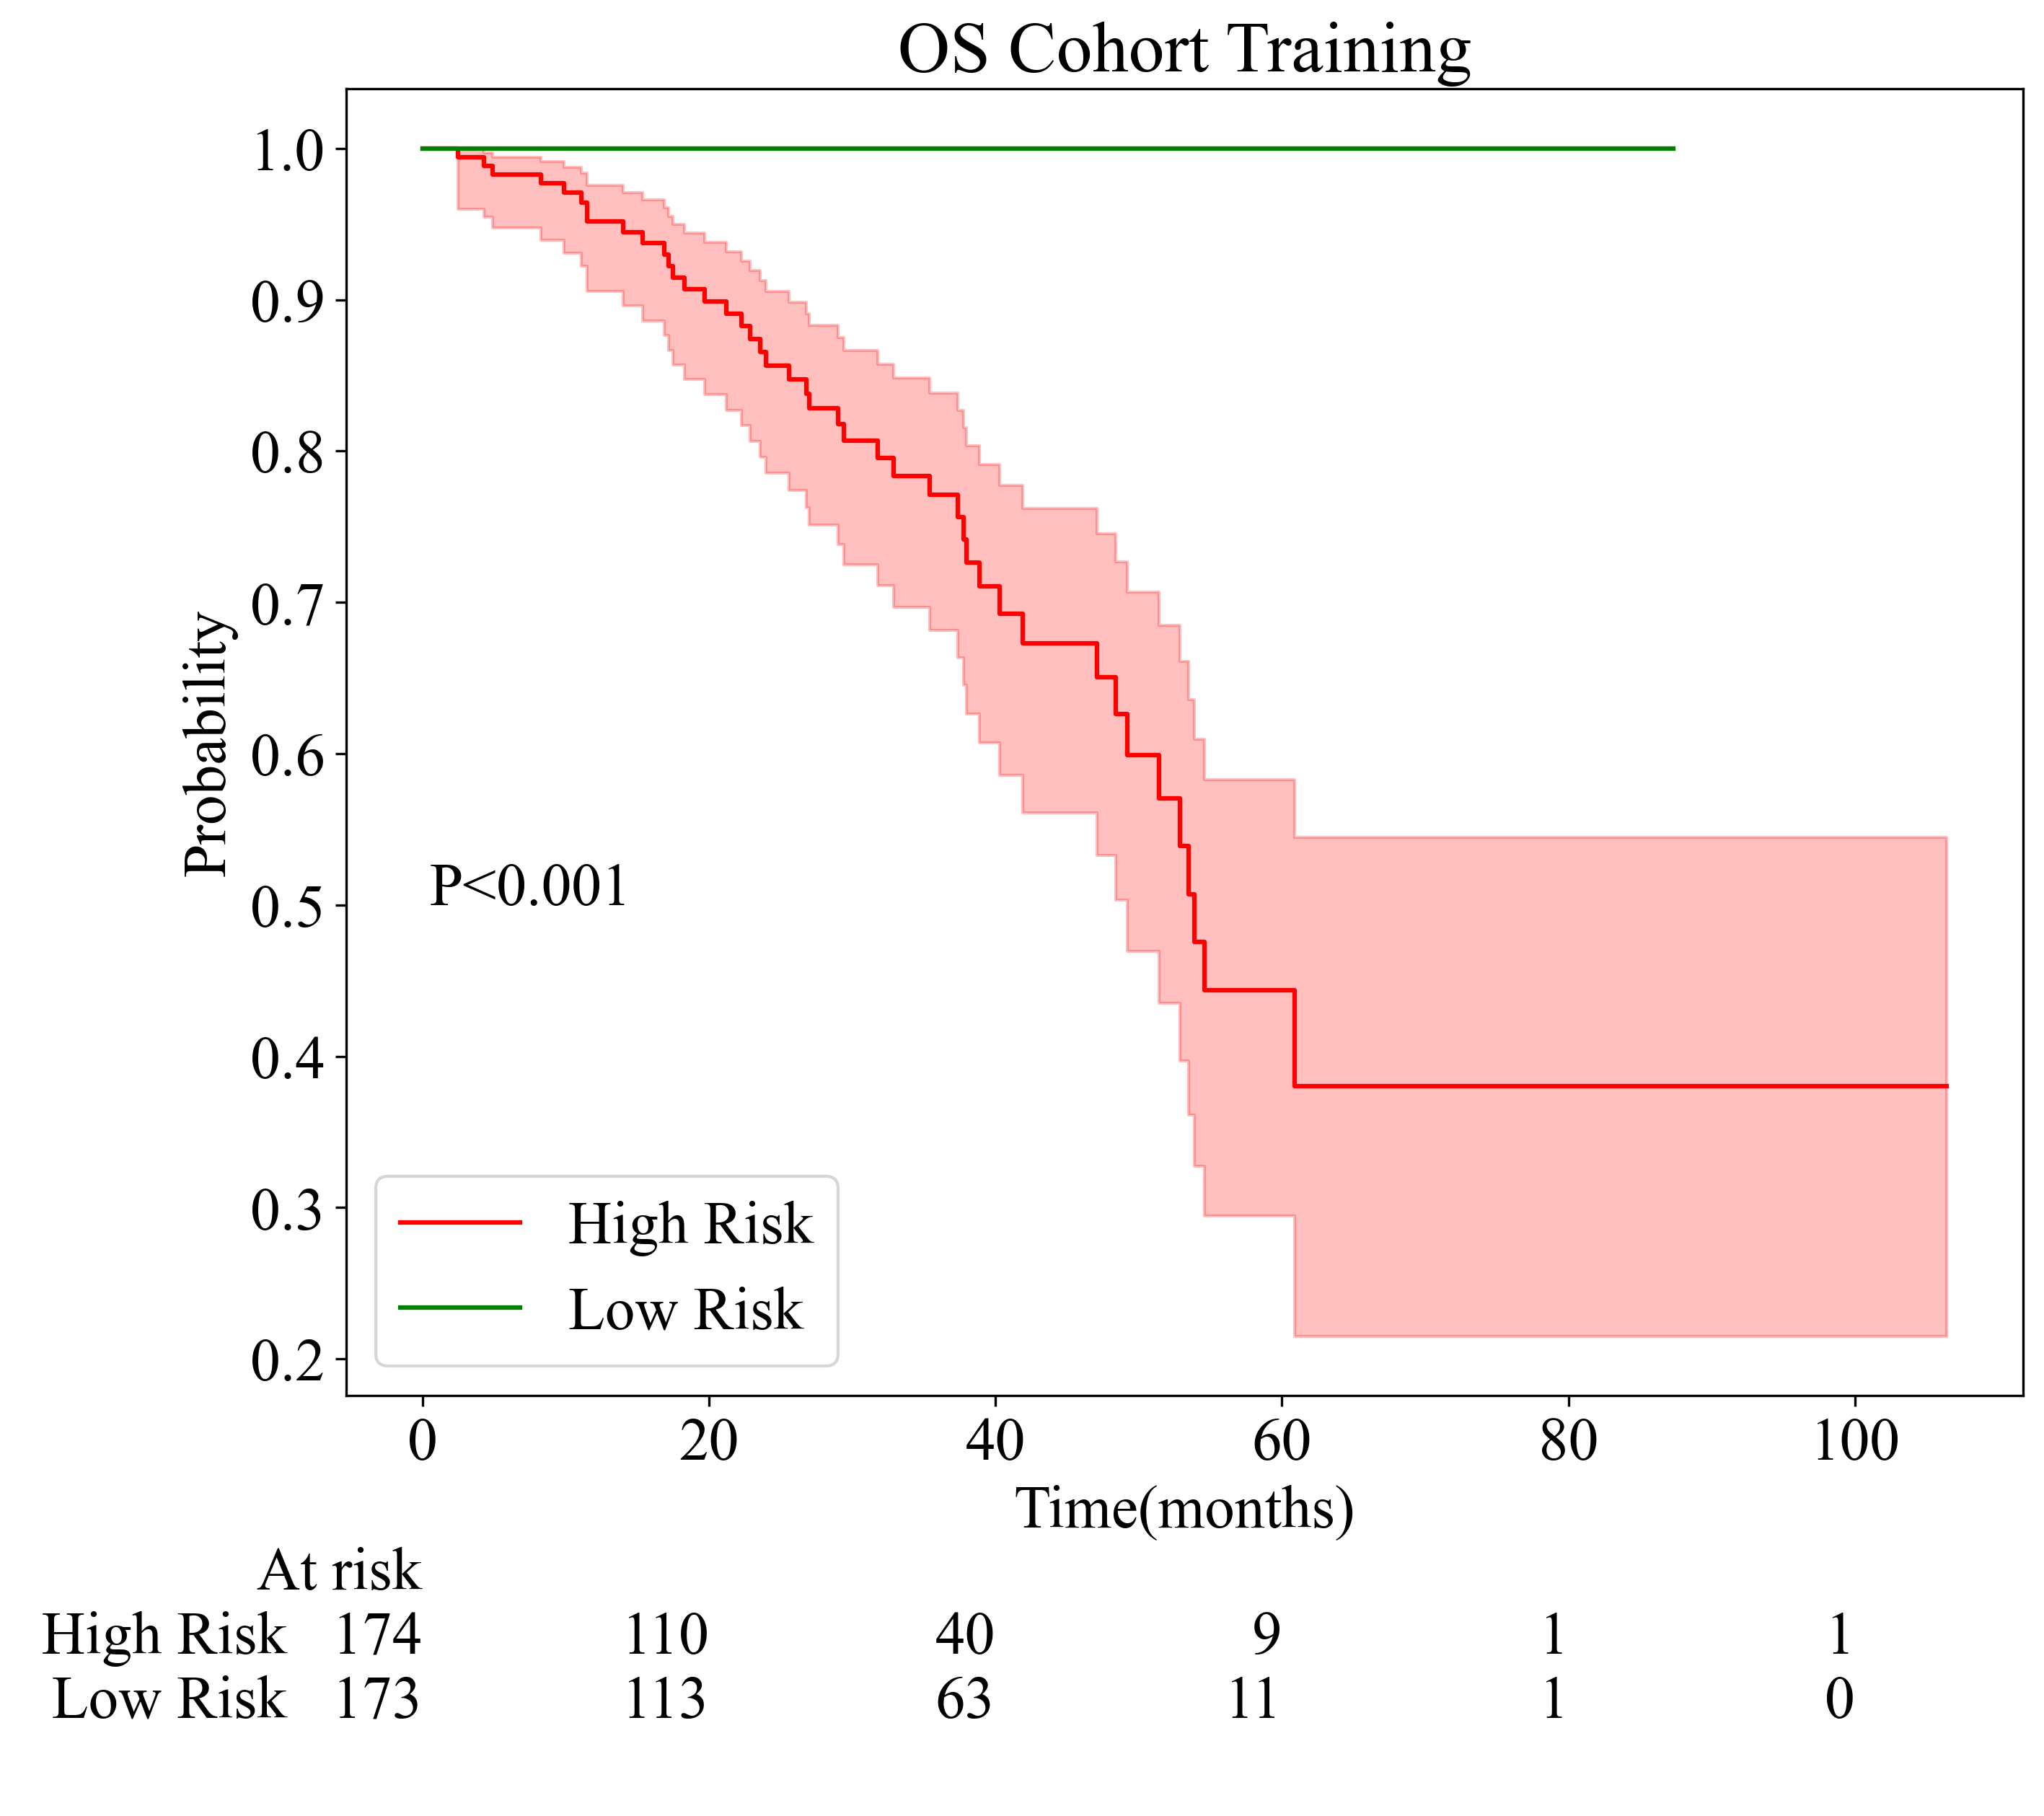

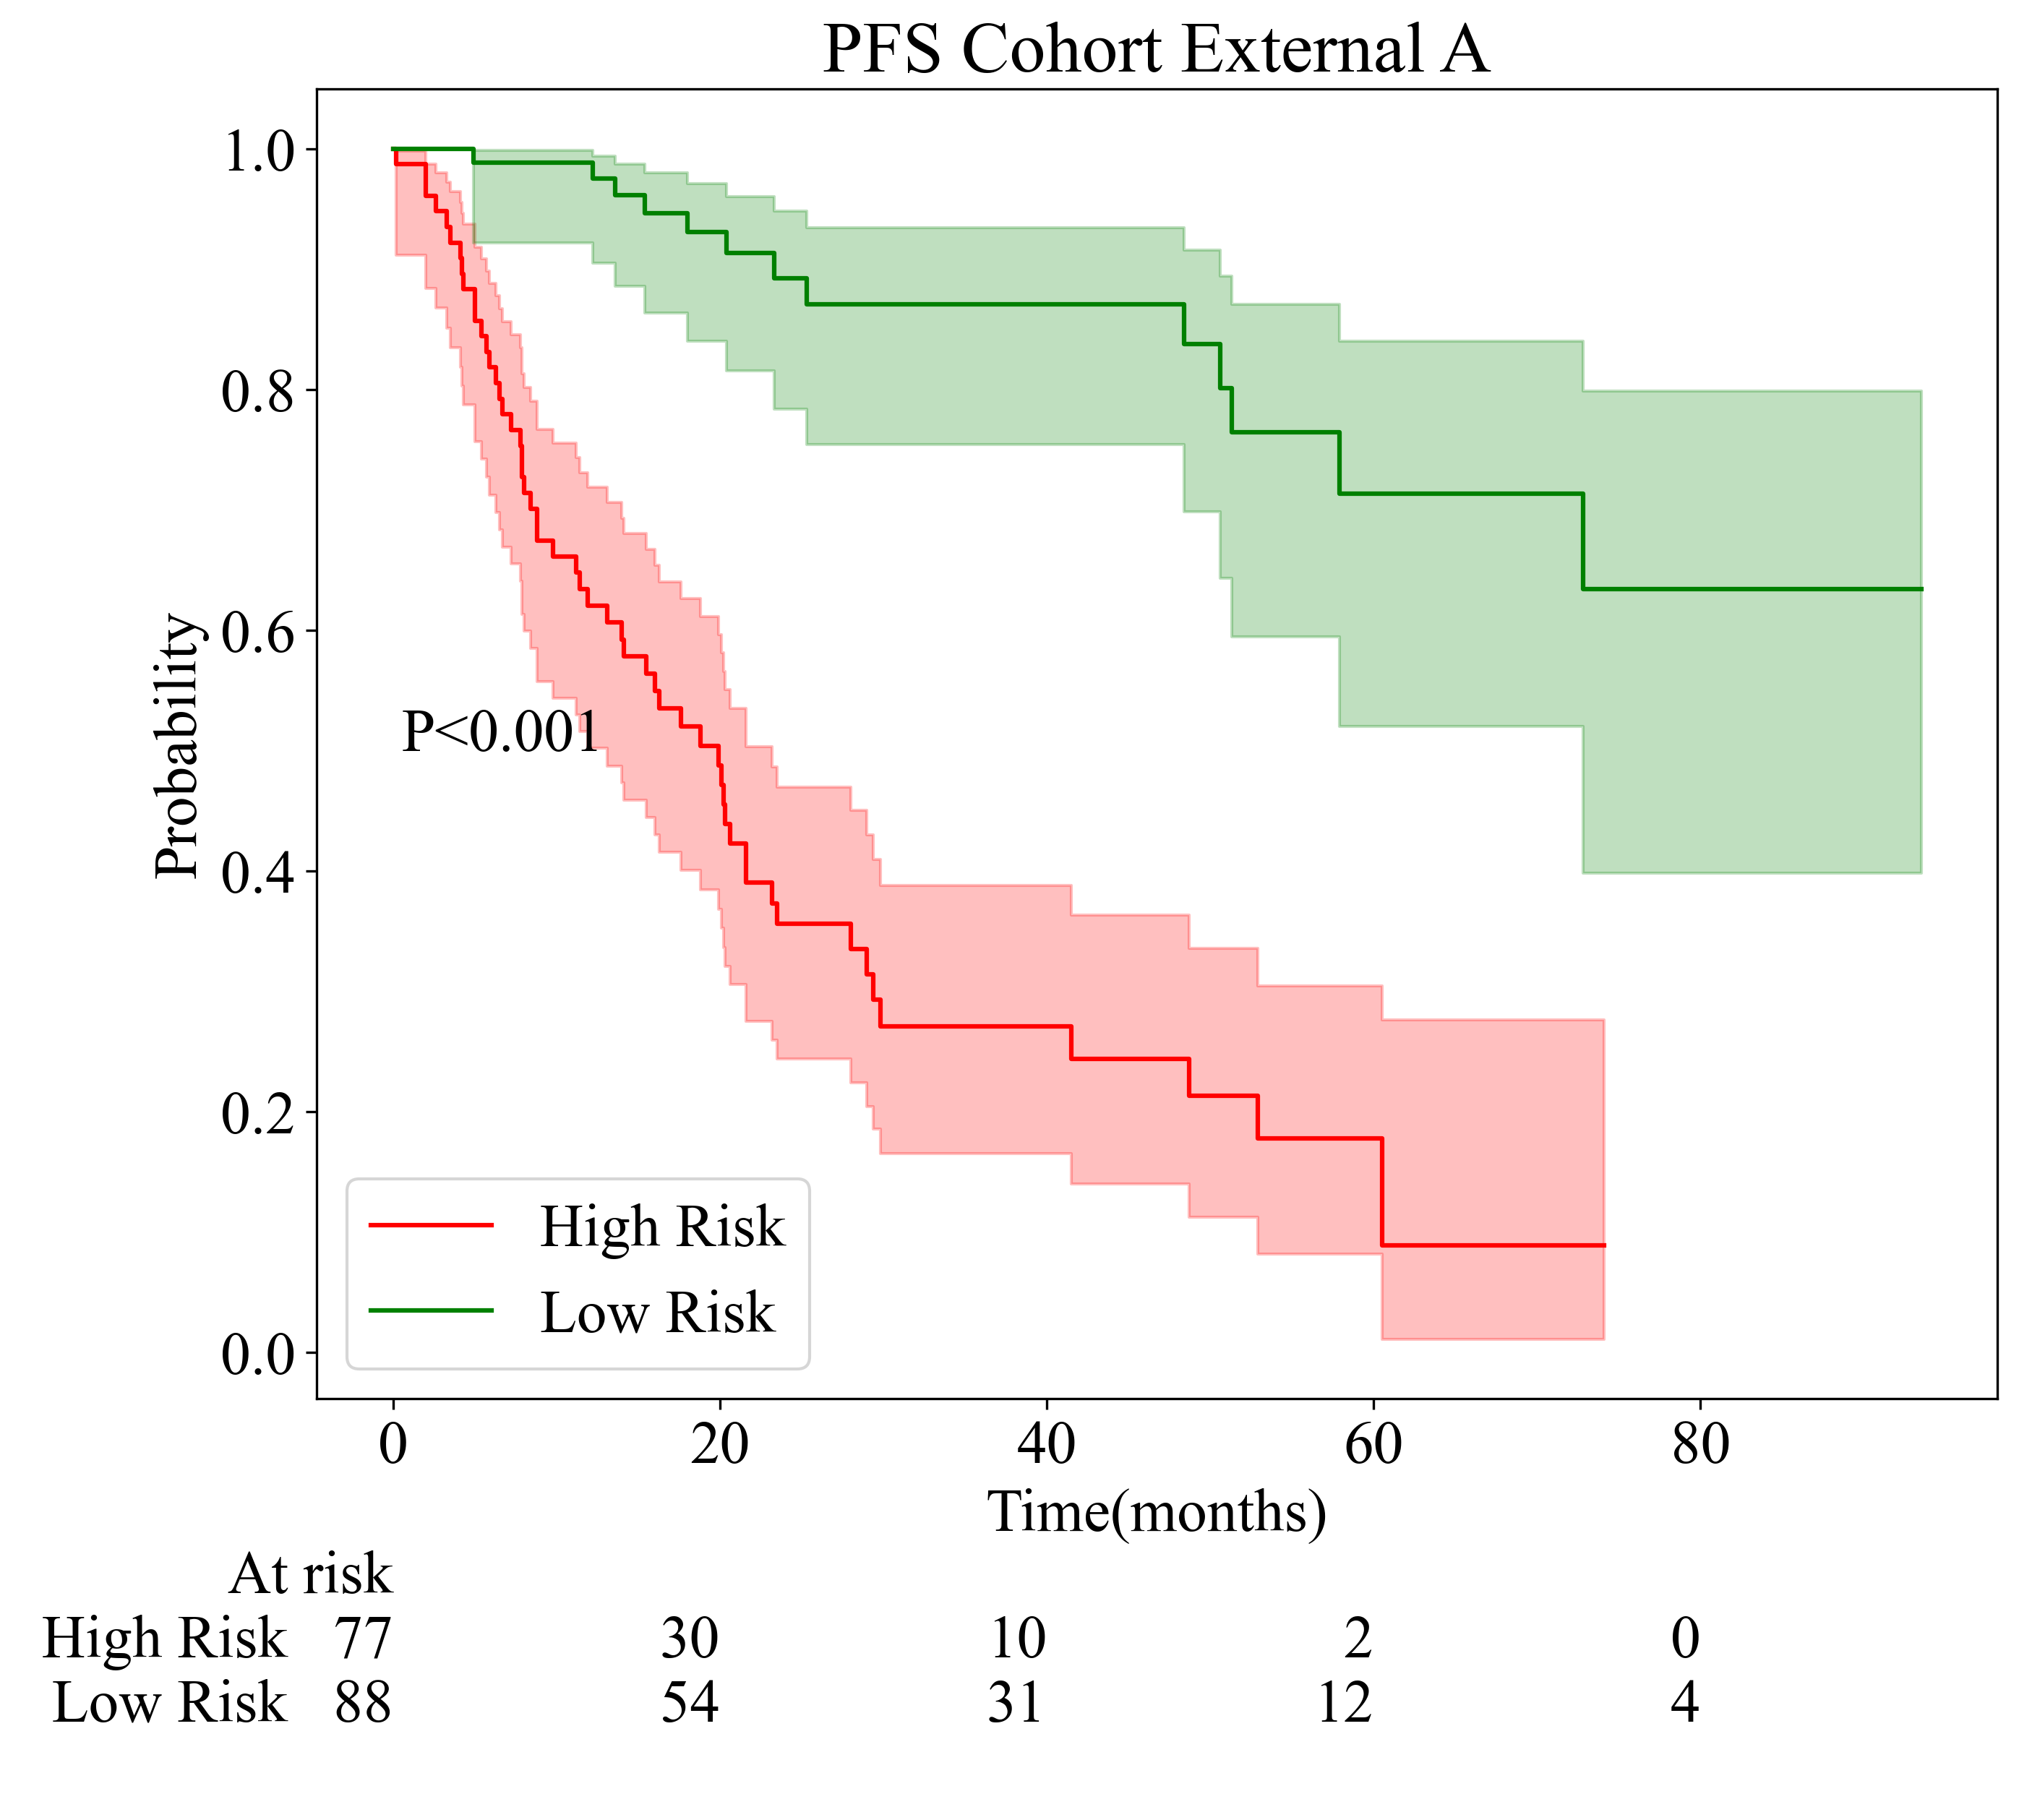

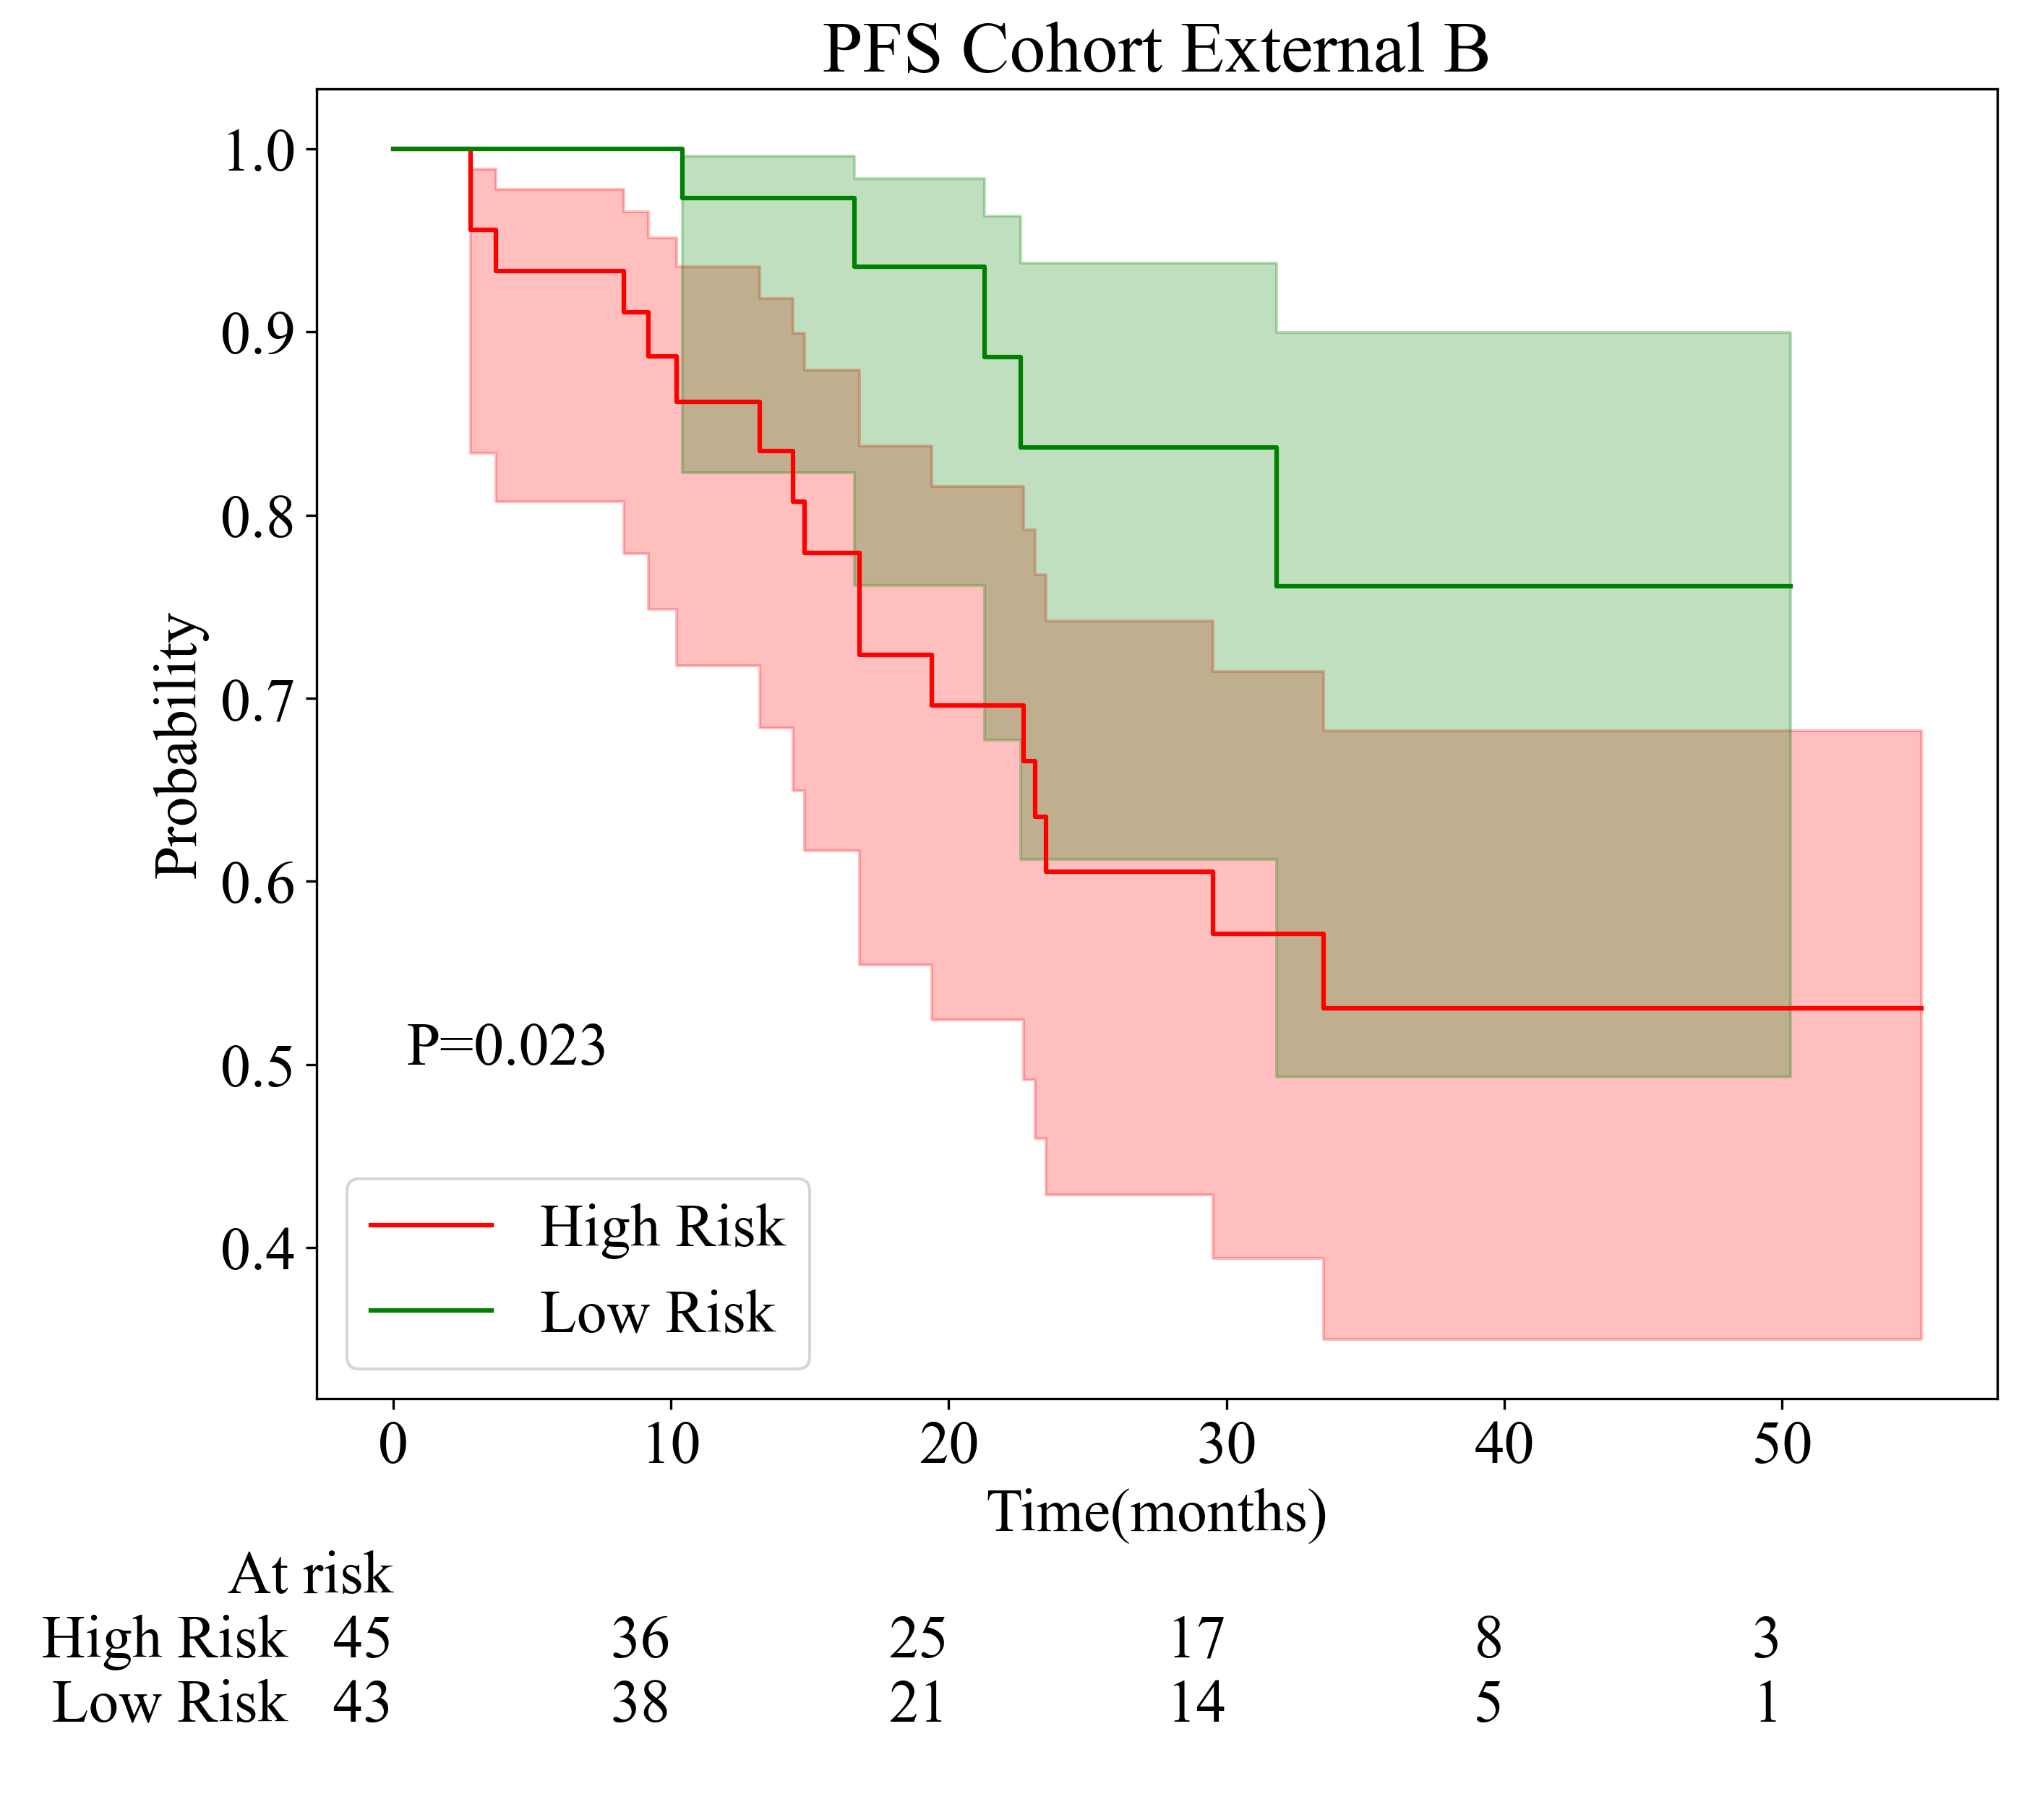

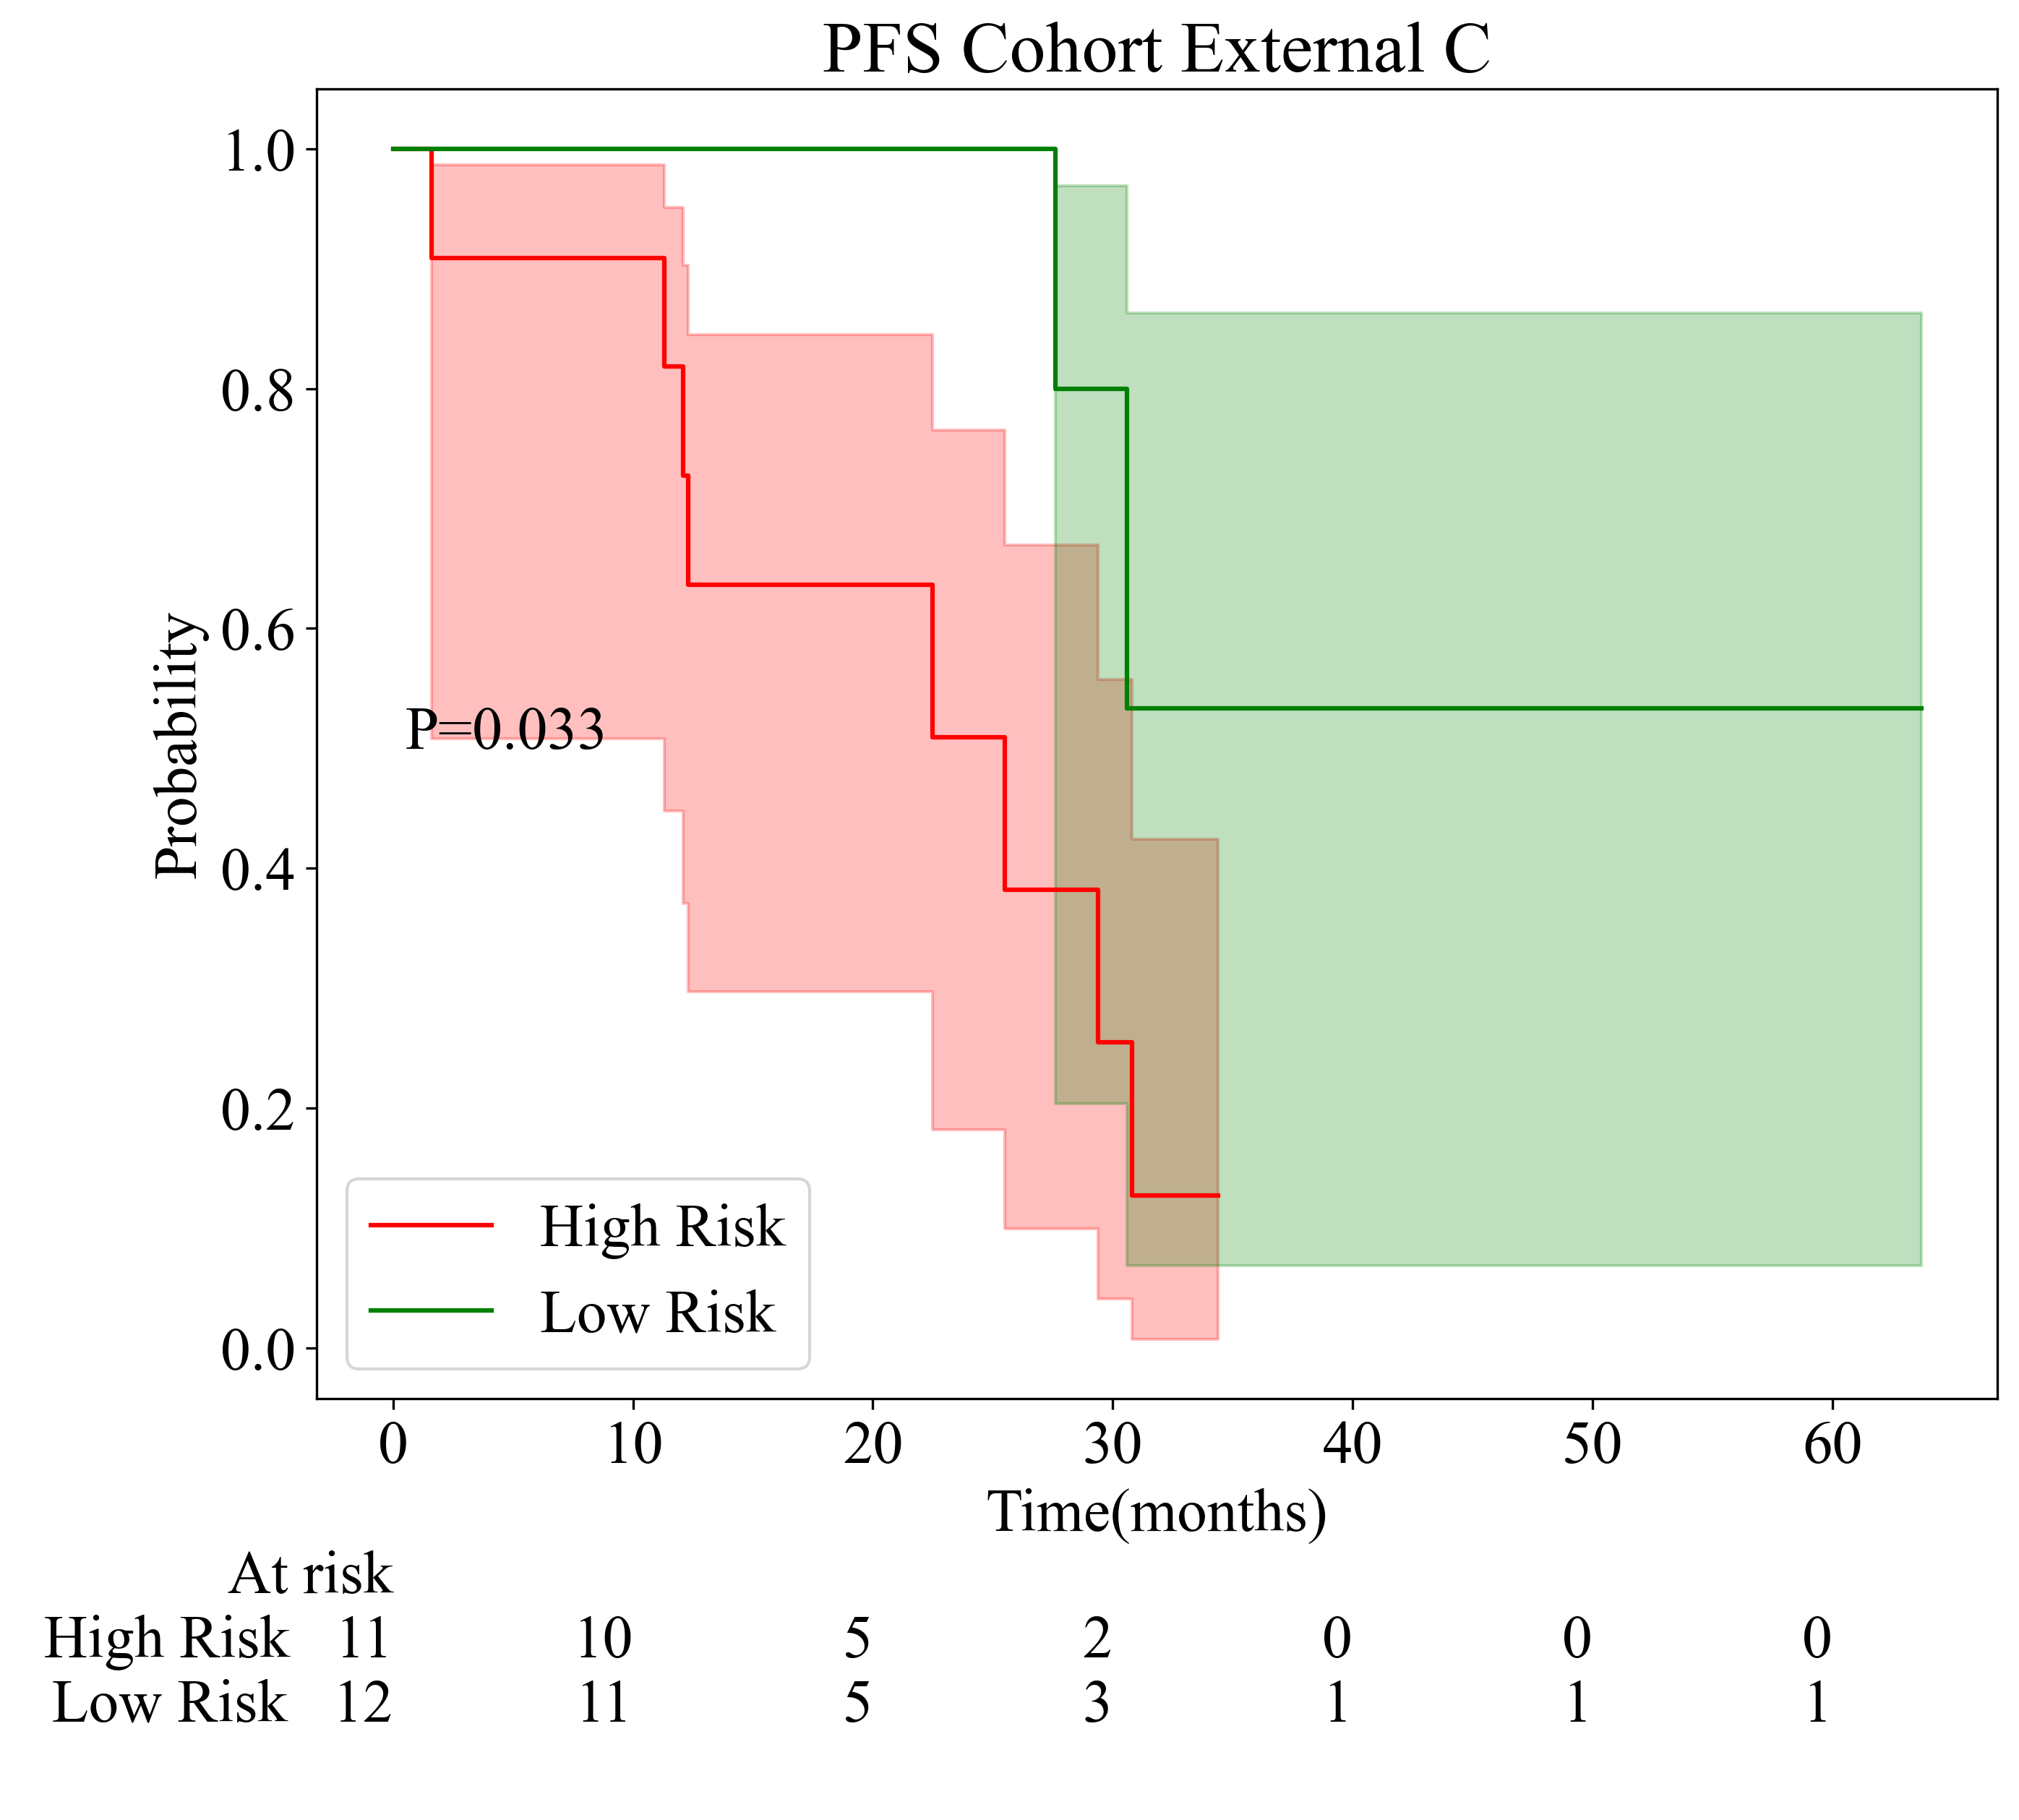

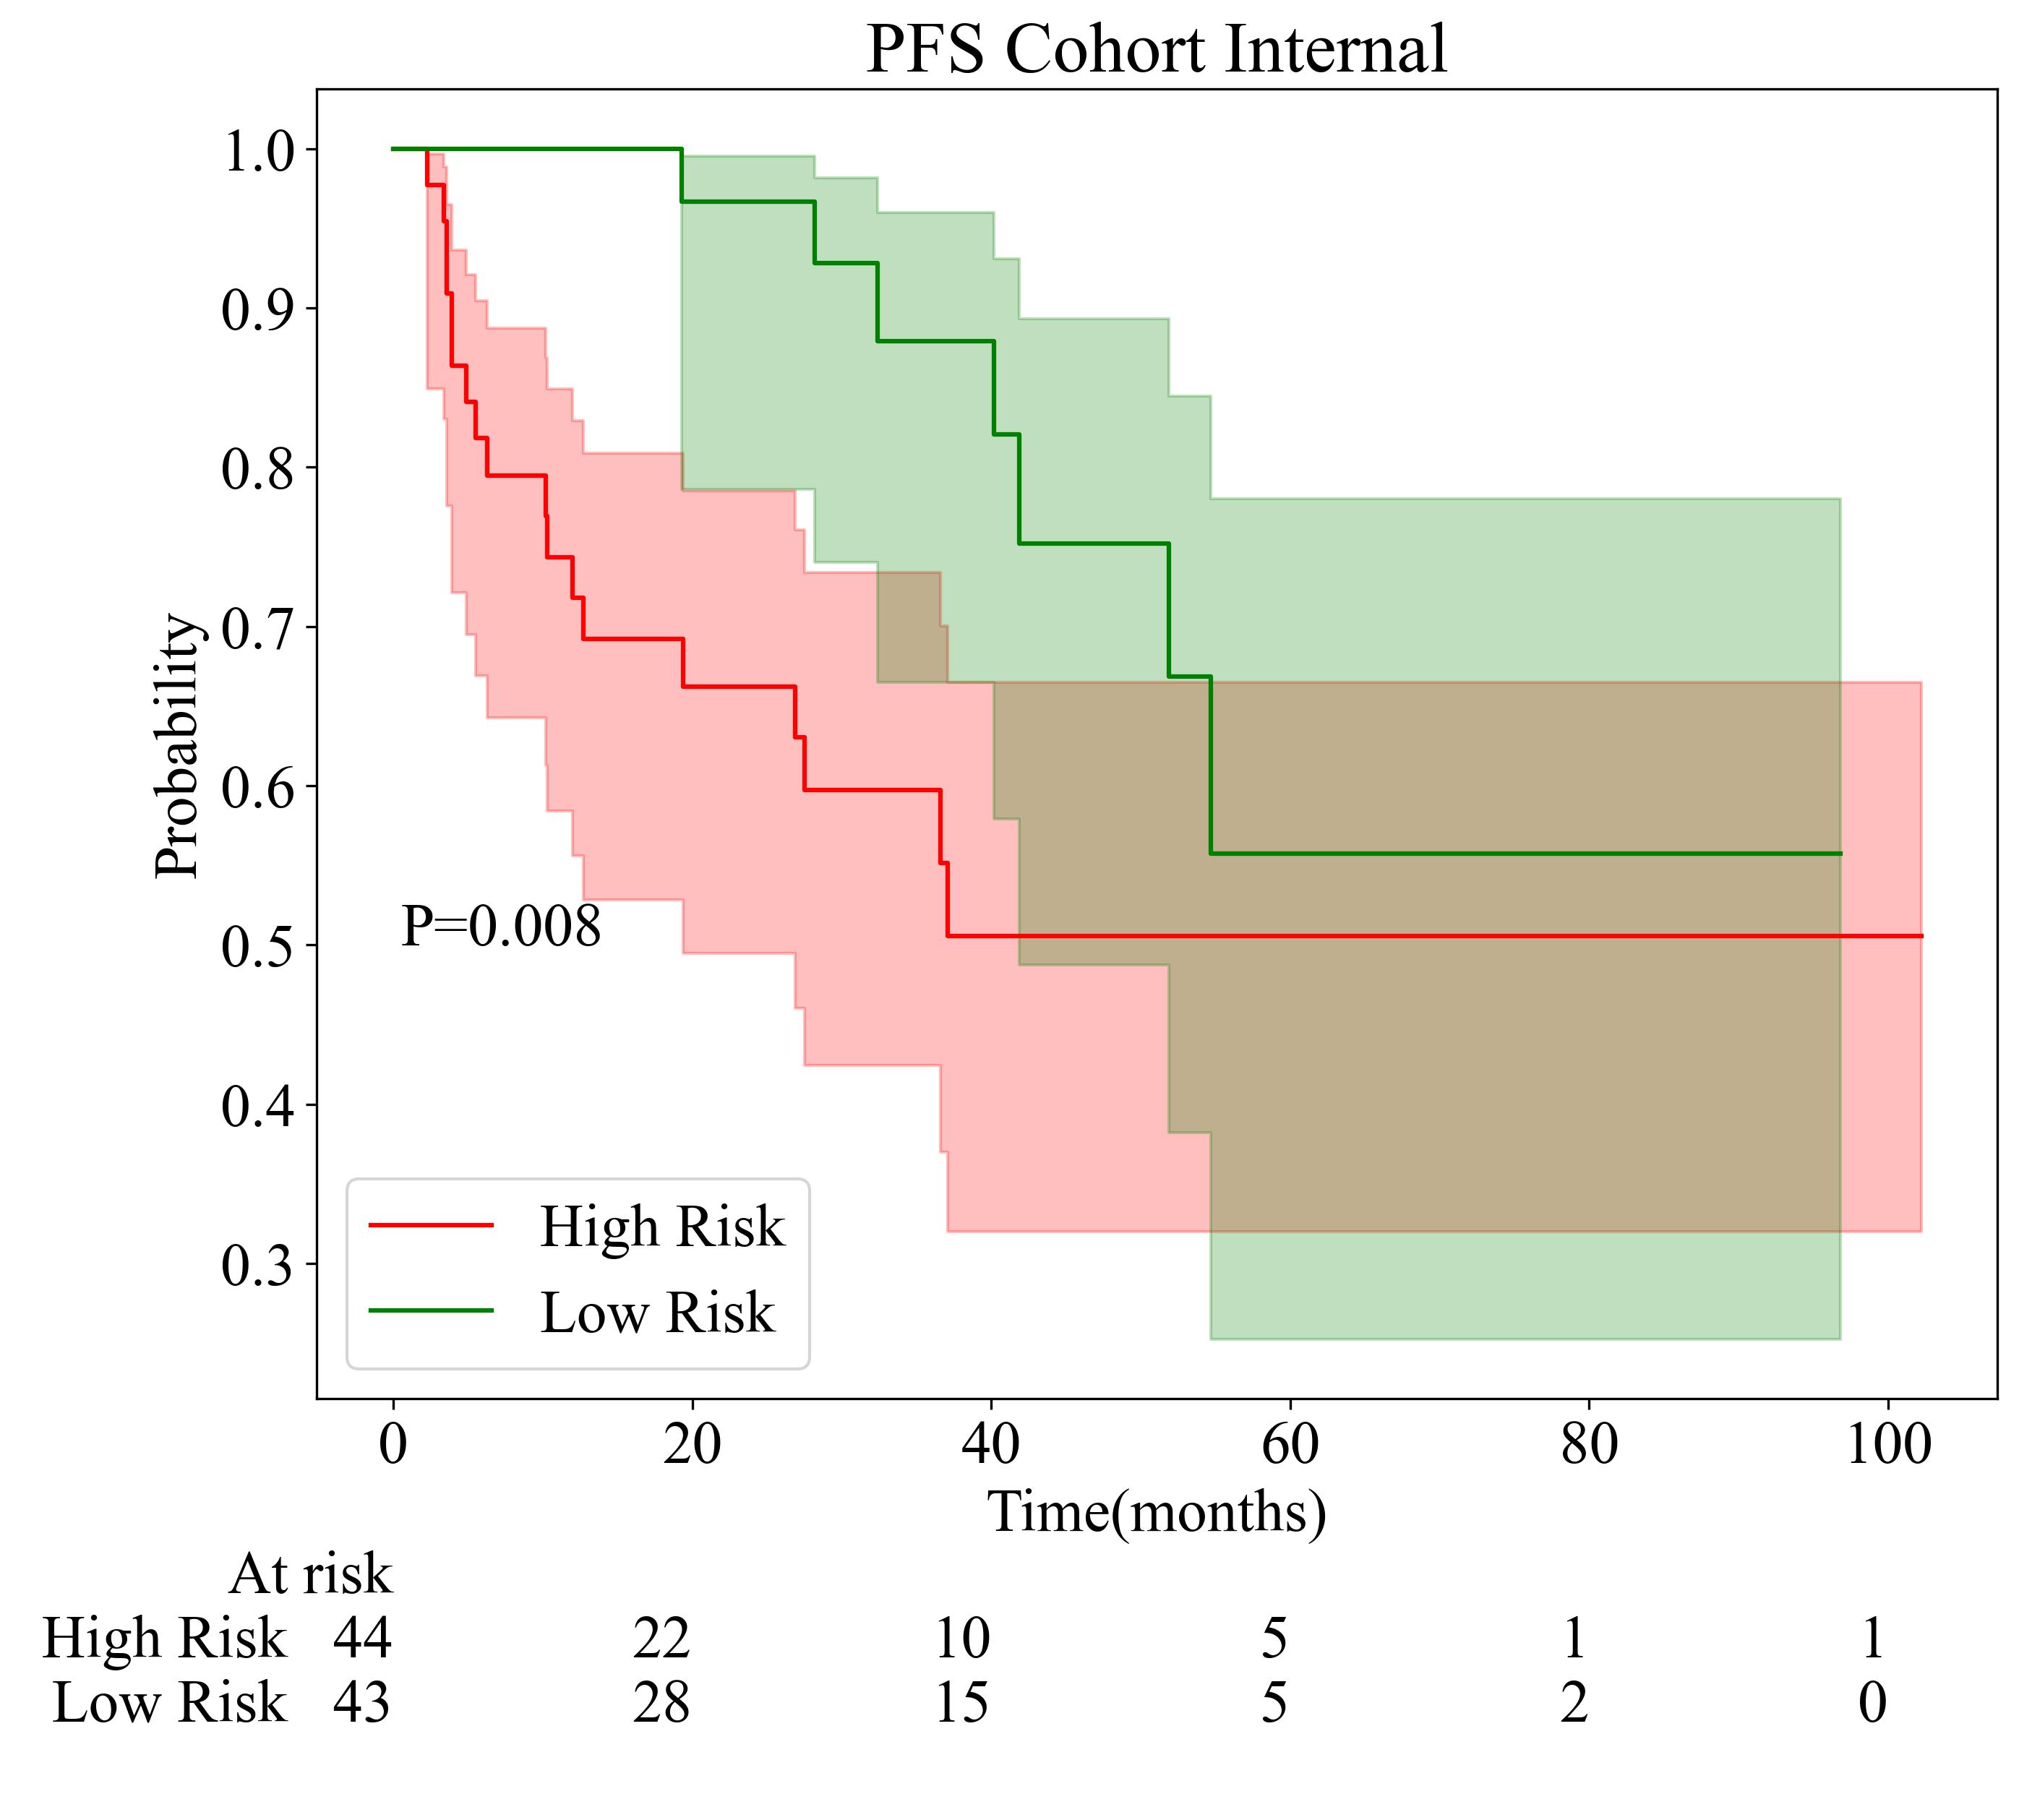

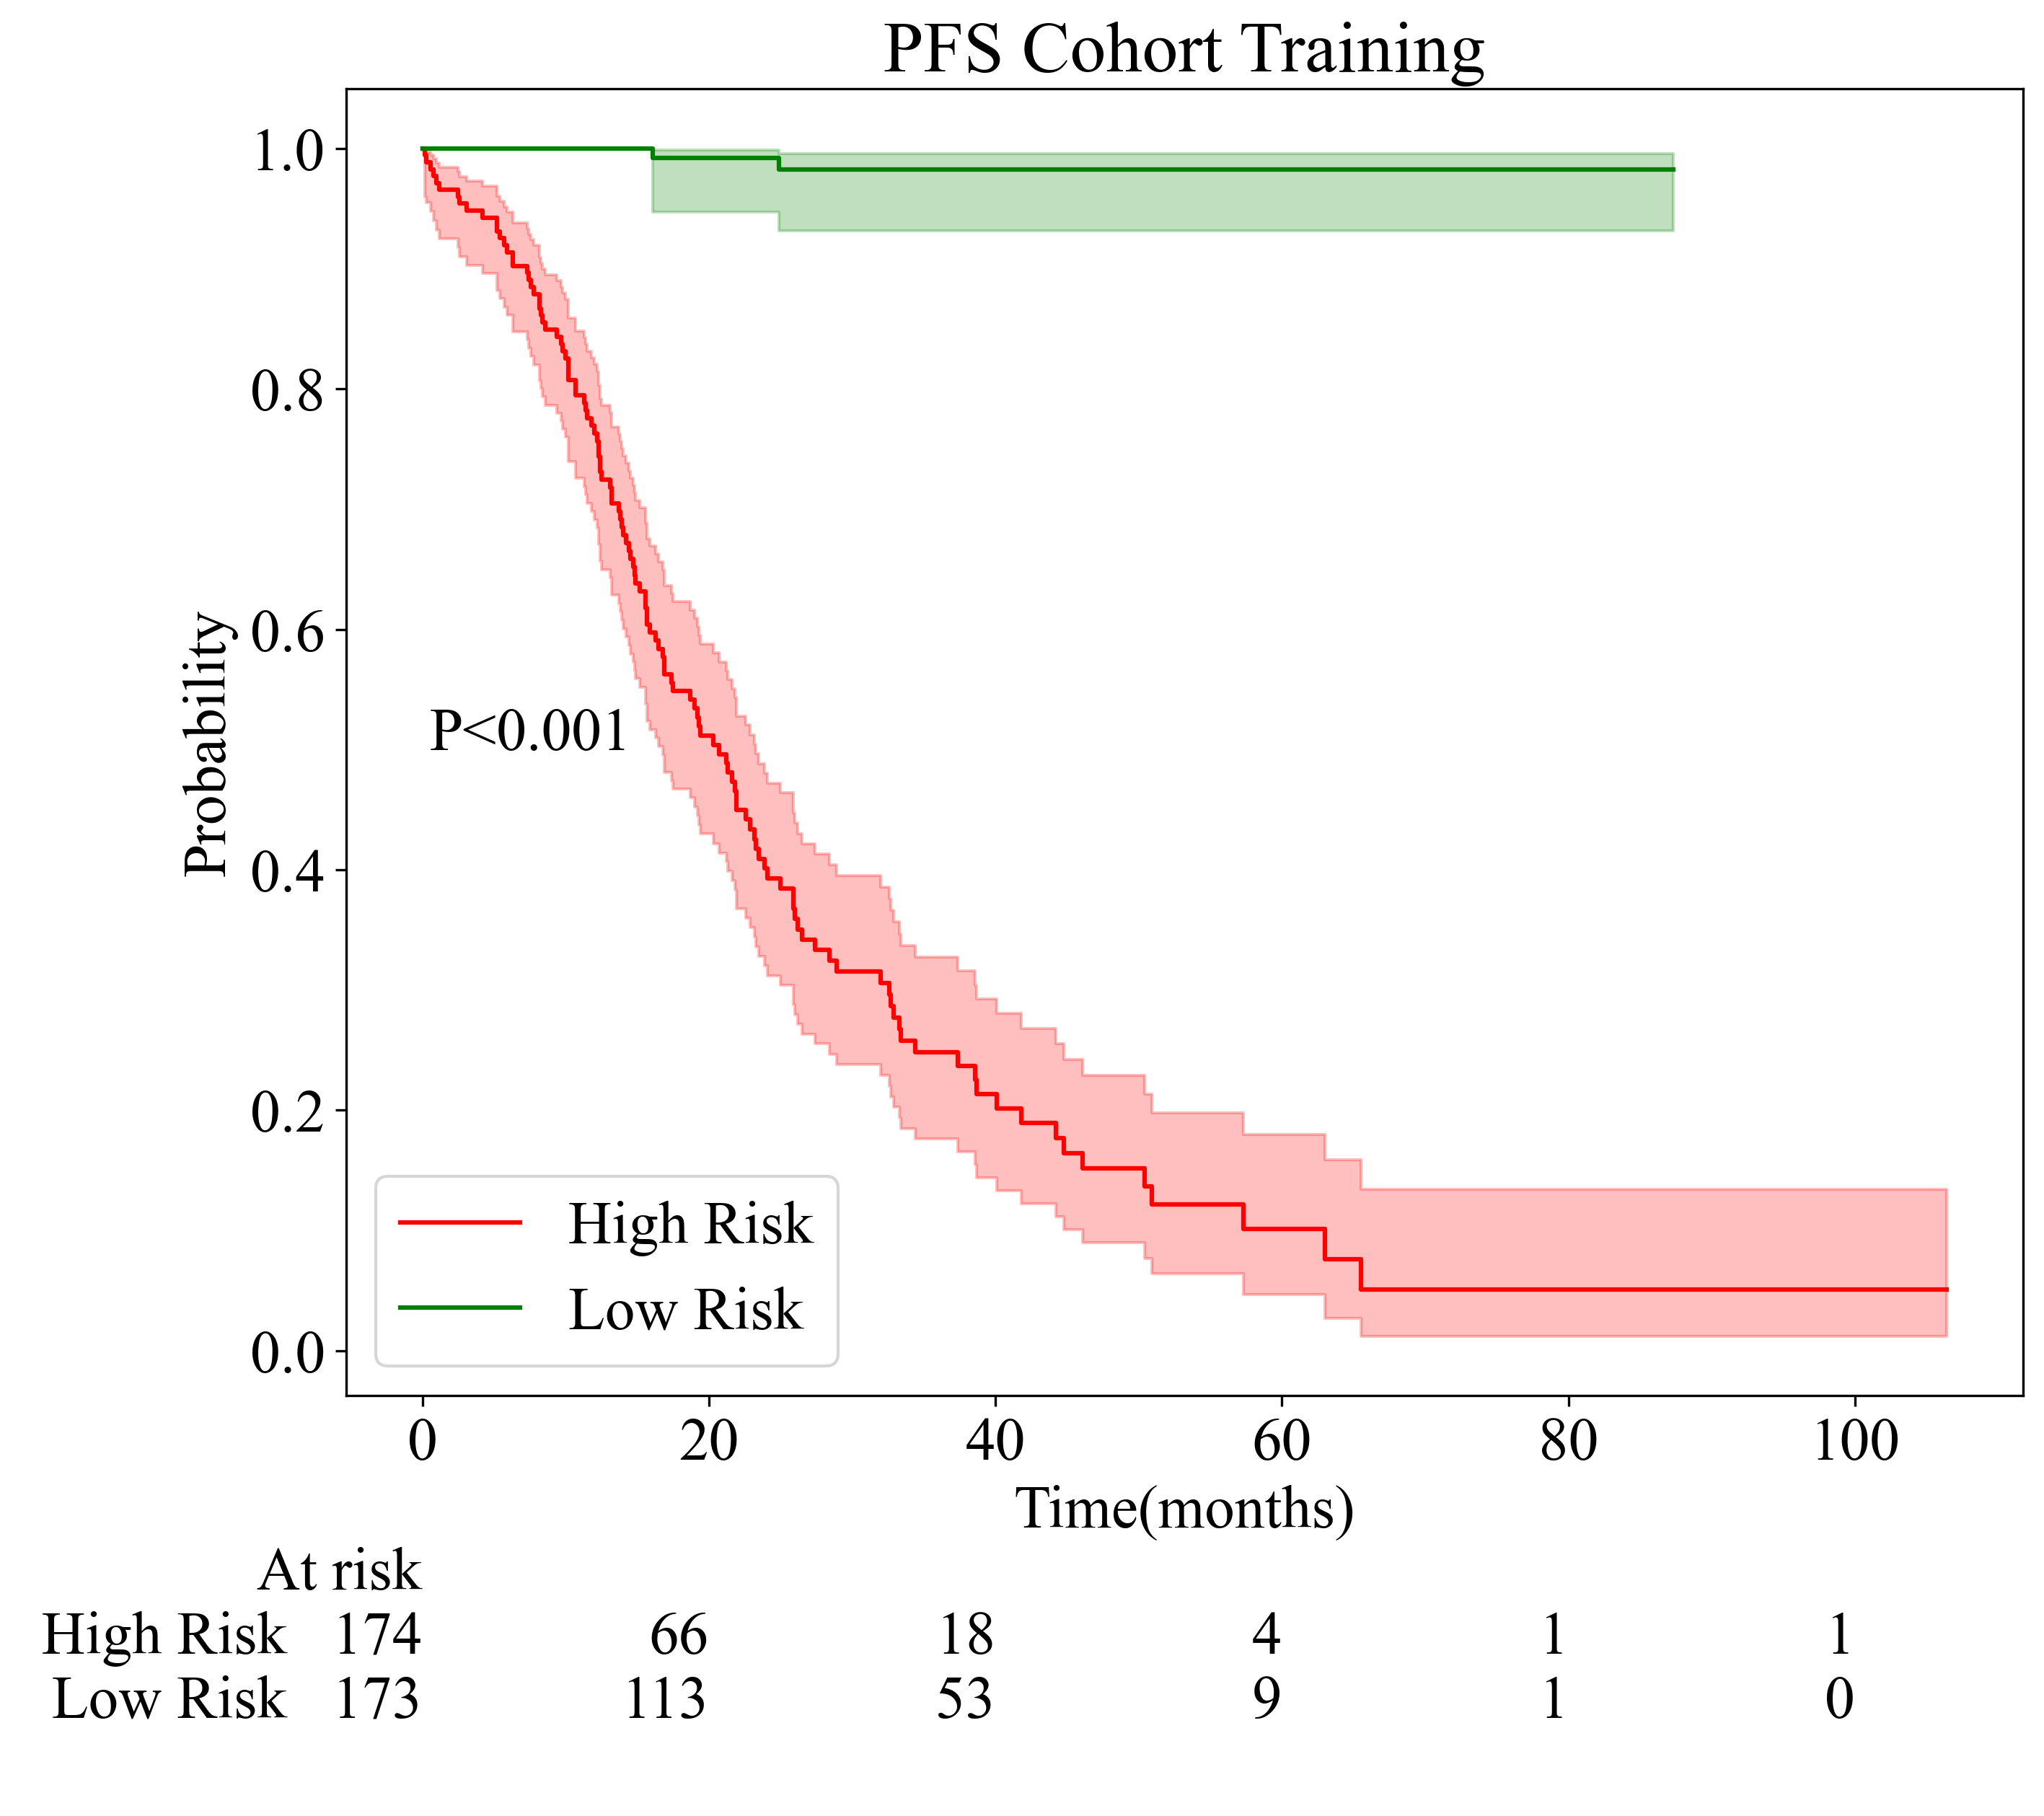

In [2]:
import os
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import matplotlib.pyplot as plt

thres = 0.001
os.makedirs('img', exist_ok=True)
loc = {'train': 0.6, 'val':0.6, 'test': 0.2, 'KH':0.2, 'CY':0.2}
duration_col = f'survival'
event_col = 'event'
for sur_task in ['OS', 'PFS']:
    for subset in np.unique(joinit_info['cohort']):
        cox_data = joinit_info[(joinit_info['cohort'] == subset) & (joinit_info['survival_type'] == sur_task)]
#         cox_data['HR'] = cox_data['risk_group'] == 'High Risk'
        dem = (cox_data['risk_group'] == 'High Risk')
        results = logrank_test(cox_data[duration_col][dem], cox_data[duration_col][~dem], 
                               event_observed_A=cox_data[event_col][dem], event_observed_B=cox_data[event_col][~dem])
        p_value = f"={results.p_value:.3f}" if results.p_value > thres else f'<{thres}'
        plt.title(f"{sur_task} Cohort {subset}")
        plt.ylabel('Probability')
        if sum(dem):
            kmf_high = KaplanMeierFitter()
            kmf_high.fit(cox_data[duration_col][dem], event_observed=cox_data[event_col][dem], label="High Risk")
            kmf_high.plot_survival_function(color='r')
        if sum(~dem):
            kmf_low = KaplanMeierFitter()
            kmf_low.fit(cox_data[duration_col][~dem], event_observed=cox_data[event_col][~dem], label="Low Risk")
            kmf_low.plot_survival_function(color='g')
        plt.legend(loc='lower left')
        plt.text(0.5, 0.7 if sur_task == 'OS' and subset in ['External B', 'Internal'] else 0.5, f"P{p_value}")
        plt.xlabel('Time(months)')
        add_at_risk_counts(kmf_high, kmf_low, rows_to_show=['At risk'])
        plt.savefig(f'img/{sur_task}_{subset}_KM.svg', bbox_inches='tight')
        plt.show()